In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd
! cp /content/drive/MyDrive/Colab\ Notebooks/dynap/DynapSE.py /content/DynapSE.py
! cp -r /content/drive/MyDrive/Colab\ Notebooks/dynap/parameters /content/parameters
! cp -r /content/drive/MyDrive/Colab\ Notebooks/dynap/equations /content/equations

/content


# Simulating a Spiking Neural Network on DYNAP-SE

Developed by [Yigit Demirag](https://www.ini.uzh.ch/fw1/modules/ini/ini.php/people/yigit) and [Giacomo Indiveri](https://www.ini.uzh.ch/fw1/modules/ini/ini.php/people/giacomo). Adapted and extended for the course [D7064E](https://www.ltu.se/edu/course/D70/D7064E/D7064E-Neuromorf-informationsbehandling-1.225526?l=en) by Fredrik Sandin.

In this exercise you will simulate the silicon neuron and synapse circuits of a neuromorphic processor named DYNAP-SE1, shown in the figure below. Specifically, you will first see how a Differential Pair Integrator (DPI) silicon circuit is used in Dynap-SE1 to implement the fundamental dynamics of synapses and Adaptive Exponential Integrate-and-Fire (AdEx) neurons. The AdEx model of neurons is described in Chapters 5 and 6 in the Neuronal Dynamics [book](https://neuronaldynamics.epfl.ch/online/Pt2.html). Then you will learn how to set up neuron and synapse parameters, form networks of spiking neurons, and monitor the electrical signals at various stages in the chip. Finally, you will investigate the adaptive behavior of the neurons.

![DYNAP-SE1](figures/dynap-se1.jpg)

Depending on your background knowledge you may or may not be able to figure out (with reasonable effort) how the synapse and neuron circuits function. Do not feel discouraged if underlying aspects of the hardware simulation are difficult to understand. After all, how much do you know about the inner workings of a modern CPU or GPU, and the transistor circuits actually used to implement the logic gates? As programmers and engineers we can anyway be productive by understanding such things at some level of abstraction. Few know the details well. Similarly, for neuromorphic hardware we must establish and learn abstract concepts that are useful for system design and engineering purposes.

This exercise will enable you to familiarize with some unique features of **dynamic** neuromorphic processors, abstractions that are key to understanding what Neuromorphic Computing is about and how it is different from Digital Computing. There is plenty of room for deepening your knowledge of the DYNAP-SE1 and dynamic neuromorphic processors by studying the references provided below and in the associated lectures.

The original version of this notebook was shared at the NICE 2021 workshop and can be obtained [here](https://code.ini.uzh.ch/yigit/NICE-workshop-2021.git).

## Examination

There are several tasks below involving investigations that require visualisation and modification of parameter values. Read the associated text carefully and do your best to understand how/why the modifications done provide the expected result (with the time given for this exercise). When you are done you should sign up for explaining your solutions to a teacher according to the instruction in Canvas.


## Part 1: Simulation of neuron and synapse circuits
---

#### Differential Pair Integrator (DPI)

The computational principles of the brain are vastly different from conventional computers. Rather than using Boolean logic, clocked operation, and distinct memory and processing units, the biological brain works at massively parallel, fault-tolerant, asynchronous manner.

In neuromorphic engineering, we aim to design compact, energy-efficient computational devices that directly _emulate_ the style of computation of the brain with **the physics of the silicon.** To achieve that, we use analog Complementary Metal-Oxide-Semiconductor (CMOS) technology to implement neural and synaptic circuits and integrate into Very Large Scale Integration (VLSI) devices. In these architectures, time represents itself (no clock) - neurons process the incoming spikes as they arrive and produce output spikes in real-time. Consequently, to process real-world sensory signals efficiently, neuromorphic systems use circuits with biologically plausible time constants that match environment statistics ($\sim 10-100$ ms).

The DPI circuit shown below is the fundamental building block used to implement silicon neurons and synapses with tunable time-constants (for details see the paper by Chicca et al referenced below).

![DPI circuit](figures/DPI_advanced.png)

It is totally fine if you do not understand how this circuit works. The essence is that it has the response dynamics, i.e., the relation of input current $I_{i n}$ and output current $I_{out}$ of

$$\tau \frac{d}{d t} I_{o u t}+I_{o u t}=\frac{I_{g}}{I_{\tau}} I_{i n},$$

where $\tau \triangleq C U_{T} / \kappa I_{\tau}$ ($C$ the capacitor, $U_T$ thermal voltage, $\kappa$ subthreshold slope factor). The DPI circuit can be tuned by adjusting the time constant by $I_{\tau}$ and the gain factor by $I_{g}$. Thus, the DPI circuit is simply a current-mode low pass filter with adjustable gain and time-constant. This is the building block of silicon neurons and synapses in the DYNAP-SE1.

#### Silicon Neuron

![Neuron circuit](figures/neuron.png)

The above schematic shows the neuron circuit implementing Adaptive Exponential Integrate & Fire (AdEx) on Dynap-SE1. AdEx neurons are introduced by [Brette and Gerstner, 2005](https://www.readcube.com/library/a457847f-fdff-4d66-a32a-b3830a010b34:72216f6a-1527-440d-b775-be66fa7085a1) that capable of describing known neuronal firing patterns, e.g., adapting, bursting, delayed spike initiation, initial bursting, fast-spiking, and regular spiking. We will not go into detail of circuit analysis but describe the functional blocks. The yellow block is the input DPI circuit modeling neuron's leak conductance. The green block implements an additional low-pass ﬁlter that integrates the spikes and produces a slow current $I_{ahp}$ responsible for spike-frequency adaptation. The red block is a spike event generation amplifier implementing current-based positive feedback (modeling both $Na^{+}$ activation and inactivation conductances) and produces address-events at extremely low-power operation. Lastly, the blue block resets the neuron and keeps it in a resting state for a refractory period, set by the $V_{ref}$ bias voltage. Under some assumptions, the response dynamics of neuron block is:

$$\tau \frac{d}{d t} I_{m e m}+I_{m e m} \approx I_{i n}-I_{a h p}+f\left(I_{m e m}\right)$$
$$\tau_{a h p} \frac{d}{d t} I_{a h p}+I_{a h p} \approx I_{a h p} \delta\left(t_{s p i k e}\right)$$


Here, $I_{m e m}$ is the sub-threshold current that represents the real neuron's membrane potential variable, $I_{i n}$ is the input current that enters the neuron, $I_{a h p}$ characterizes the spike adaptation effect, $\tau$ is the time-constant of leakage current. $f(x)$ is an exponential function with positive exponent which characterizes the passive properties, i.e. $f(x) = \alpha e^{ \beta x - \gamma} + \delta$.

#### Silicon Synapse

![Synapse circuit](figures/synapse.png)

Lastly, the above schematic shows a typical silicon synapse circuit implemented on Dynap-SE1. The green block implements short-term depression (STD). The yellow block implements basic DPI dynamics and can be tuned to implement short-term facilitation (STF). The red block implements NMDA voltage-gated channels, and the blue block implements conductance-based voltage dependence. The simplified version of the response dynamics of the synaptic block is:

$$\tau \frac{d}{d t} I_{s y n}(t)+I_{s y n}(t)=I_{w} \delta\left(t_{p r e}\right)$$
where $I_{s y n}$ is the synaptic current, $I_{w}$ is the gain factor (weight) of the synapse, and $\tau$ is time constant of current decay.

For more detailed explanations of neural and synaptic circuits (and especially the derivations and the assumptions behind the formulas mentioned) you can check [PDF available on arXiv.](https://arxiv.org/pdf/1403.6428.pdf)

>Chicca, E., Stefanini, F., Bartolozzi, C., Indiveri, G. (2014). [Neuromorphic Electronic Circuits for Building Autonomous Cognitive Systems](https://doi.org/10.1109/JPROC.2014.2313954), Proceedings of the IEEE  102(9), 1367-1388.

### Setting up the network

We will use [Brian2](https://brian2.readthedocs.io/en/stable/) to implement our spiking neural network. There are other options available (NEST, PyTorch, etc.), but Brian2 is both fast and flexible when working with spikes. More importantly, the group who developed DYNAP-SE1 has already modeled the neural and synaptic circuits that the processor implements using Brian2. Thus, it is straightforward to model DYNAP-SE1 in Brian2 and simulate spiking neural networks as if they would be running on an actual processor. Super cool :)

So, let's start with importing Brian2.

In [ ]:
!pip install brian2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.3 MB/s eta 0:00:00


In [ ]:
from brian2 import *

Brian2 allows us to write models for neuron and synapses,  create large populations of neurons, and connect them arbitrarily. On the other hand, the real chip has predefined resources, and circuits are fixed. There is no time-multiplexing of resources. Hence for this session, we created a simple `DynapSE.py` wrapper class that implements DPI neuron and synaptic circuit models and  monitors chip resources (e.g., number of available neurons per core, number of synapses between neurons, etc.)

In [ ]:
from DynapSE import DynapSE

We then import dynamical array processing (Numpy) and plotting (Matplotlib) libraries.

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Display plots inside Jupyter cell
%matplotlib inline
# Set the dots-per-inch resolution of the images
mpl.rcParams['figure.dpi'] = 90

The ordinary differential equations defining neuron and synapse models should be accessible by Brian2. Let's import the DYNAP-SE1 model equations and their parameters. Also define some Brian2 settings and optionally enable compilation of the differential equations for faster execution if you have installed a compatible C++ compiler.

In [ ]:
# Import the DYNAP-SE1 equations describing DPI synapses and AdEx neurons
from equations.dynapse_eq import *

# Import default parameter settings for DYNAP-SE1
from parameters.dynapse_param import *

# Ignore Brian2 base warnings
BrianLogger.suppress_name('base')

# The clock of Brian2 simulation for numerically solve ODEs
defaultclock.dt = 20 * us

# Optionally enable C++ code generation for faster spiking network simulation.
# Requires a compiler, e.g., Visual Studio.
# set_device('cpp_standalone', build_on_run=True)


### Generating Input Spike Pattern

The language of neuromorphic chips is spike trains. Whether we want to process the analog or digital signal, we need to convert it to spikes first. Inside Dynap-SE1, we have such converters, following a single protocol: AER (Address-Event Representation). AER uses (spike source address, timing) pair to define a single spike. In this exercise, we will not use AER but the Dirac delta function $\rho(t)=\sum_{i=1}^{k} \delta\left(t-t_{i}\right)$ to define spike trains.

In the cell below, you will see three different spike train implementations
`regular`, `poisson`, and `cosine`. You can change the variables in the TODO section (optional) and customize your input pattern.

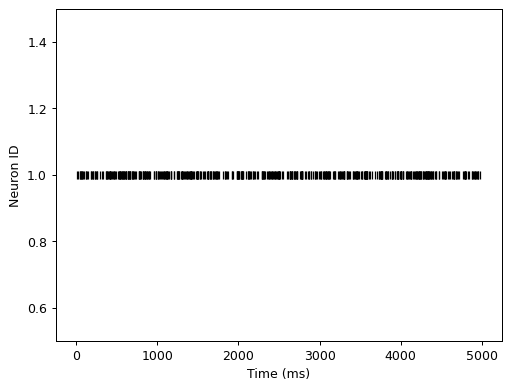

In [ ]:
# Input Generator
##################
# TODO:
# - Play with different input spike patterns by changing input_type (optional).
#
# Parameters
input_type   = 'poisson' # 'regular', 'poisson' or 'cosine' (Default: poisson)
pulse_start  = 0         # second - Start time of input (Default: 0)
pulse_stop   = 5         # second - Stop time of input (Default: 5)
inp_duration = 5         # second - Simulation duration (Default: 5)
rate         = 100       # Hz or rad/sec - Spiking rate (Default: 80 Hz for regular, 100 Hz for poission, 2 rad/sec for cosine)
##################

if input_type == 'regular':

    spikes = np.zeros(inp_duration*1000)
    dt = int(1000/rate)
    spikes[pulse_start*1000:pulse_stop*1000:dt] = 1.0

if input_type == 'poisson':

    prob = rate * 1e-3
    mask = np.random.rand(inp_duration*1000)
    spikes = np.zeros(inp_duration*1000)
    spikes[mask < prob] = 1.0
    spikes[:pulse_start*1000]=0
    spikes[pulse_stop*1000:]=0

if input_type == 'cosine':

    spikes = np.zeros(inp_duration*1000)
    time = np.linspace(0, inp_duration, inp_duration*1000)
    co = np.cos(2 * np.pi * rate * time)
    mask = 20 * np.random.rand(inp_duration*1000)
    spikes[mask < co] = 1.0
    spikes[:pulse_start*1000]=0
    spikes[pulse_stop*1000:]=0

plt.plot(spikes,'k|')
plt.xlabel("Time (ms)")
plt.ylabel("Neuron ID")
plt.ylim(0.5, 1.5)
plt.show()

Now that we have an input spike pattern, we need to tell Brian2 to use the spikes we just generated. To do that, we define two arrays specifying spike indices (ID of spike source) and the spike timing. The sizes of two arrays match since Brian2 will check both and assign spike timings to spike sources. We will have single source ID because we generated only one spike pattern.

In [ ]:
# Reinitialize the device
device.reinit()
device.activate()
defaultclock.dt = 20 * us

spike_timing = np.where(spikes==1)[0] * ms # Timing of spikes
neuron_indices = np.zeros(len(spike_timing)) # ID of spike sources
### Below we use SpikeGeneratorGroup to define one neuron (neuron 0) and it will spike at the spike_timing
input_spike_generator = SpikeGeneratorGroup(1, indices=neuron_indices, times=spike_timing, name='InpSpikeGenerator')

In [ ]:
spike_timing

array([0.014, 0.028, 0.043, 0.05 , 0.062, 0.067, 0.071, 0.079, 0.083,
       0.096, 0.124, 0.127, 0.135, 0.145, 0.183, 0.185, 0.2  , 0.208,
       0.215, 0.23 , 0.232, 0.248, 0.255, 0.261, 0.289, 0.317, 0.333,
       0.365, 0.375, 0.381, 0.387, 0.392, 0.406, 0.413, 0.419, 0.42 ,
       0.422, 0.428, 0.439, 0.455, 0.47 , 0.472, 0.48 , 0.497, 0.521,
       0.529, 0.53 , 0.541, 0.542, 0.544, 0.552, 0.56 , 0.565, 0.576,
       0.584, 0.587, 0.589, 0.6  , 0.613, 0.615, 0.619, 0.635, 0.638,
       0.645, 0.647, 0.652, 0.661, 0.666, 0.668, 0.685, 0.69 , 0.696,
       0.705, 0.714, 0.729, 0.74 , 0.77 , 0.775, 0.779, 0.782, 0.792,
       0.798, 0.821, 0.824, 0.828, 0.833, 0.846, 0.85 , 0.851, 0.861,
       0.868, 0.871, 0.888, 0.898, 0.903, 0.908, 0.958, 0.965, 0.984,
       0.989, 0.991, 1.01 , 1.014, 1.024, 1.031, 1.051, 1.06 , 1.077,
       1.079, 1.084, 1.094, 1.112, 1.113, 1.115, 1.116, 1.118, 1.129,
       1.142, 1.168, 1.17 , 1.175, 1.205, 1.208, 1.242, 1.249, 1.25 ,
       1.254, 1.258,

### Creating a Network

To create a spiking neural network on Brian2, there are three pillars we need to understand. Brian2 requires the `Network()` instance, which handles the running of the simulation.  It contains a set of Brian objects (e.g., neurons, synapses, monitors, etc.) added with `add()` function. The final `run()` method runs the simulation.

After creating a `network` instance, we will pass it to the `DynapSE()` method to create a  new `chip` instance. Creating a spiking neural network and passing it to a neuromorphic chip class may seem peculiar. However, this will allow us to make sure that the chip can support the Brian2 network.


In [ ]:
network = Network() # Instantiate a Brian2 Network
chip = DynapSE(network) # Instantiate a Dynap-SE1 chip implementing neural and synaptic silicon dynamics


Now let's look at the inside of the Dynap-SE1 chip. Inside, there are four event-based, mixed-signal neuromorphic cores; each one has 256 DPI neurons. Each neuron is identical to the others by design; however, it may have slightly different parameters due to the noise and mismatch in analog circuits. In the simulation, you can allocate `num_n` neurons from a core `X` by using `get_neurons(num_n, 'Core_X')` method, which returns a [SubGroup](https://brian2.readthedocs.io/en/stable/reference/brian2.groups.subgroup.Subgroup.html) of DPI neurons.

An individual neuron can have a fan-in of 64 and a fan-out of 4k connections. Users can determine the types of the synapses to exhibit one of 4 different behaviors: fast excitatory (AMPA), slow excitatory (NMDA), subtractive inhibitory (GABA_A), or shunting inhibitory (GABA_B).  User can connect different neurons (which are obtained with `get_neurons()`) to each other using `add_connection(pre_population, post_population, synapse_type)` method. Synapse type can be either `AMPA`, `NMDA`, `GABA_A` and `GABA_B`.


Now, let's allocate a single neuron from the first core of Dynap-SE1, then define NMDA- and AMPA- type synaptic connections to our custom `input_spike_generator`.

In [ ]:
### Here we define a DPI neuron with 2 different kind of synapses connected

DPI_neuron  = chip.get_neurons(1, 'Core_1') # Allocate single DPI neuron from Core 1
DPI_NMDA_synapse = chip.add_connection(input_spike_generator, DPI_neuron, synapse_type='NMDA') # Define a slow excitatory synapse
DPI_AMPA_synapse = chip.add_connection(input_spike_generator, DPI_neuron, synapse_type='AMPA') # Define a fast excitatory synapse

# In Brian2 creating Synapses instance does not connect two endpoints, it only specifies synaptic dynamics
# Let's connect two endpoints and set an initial weight of 300.

chip.connect(DPI_NMDA_synapse, True)
DPI_NMDA_synapse.weight = 300

chip.connect(DPI_AMPA_synapse, True)
DPI_AMPA_synapse.weight = 300

1 neurons are allocated from Core_1.


Until now, we created a spike generator, allocated a neuron from the chip, and formed two synaptic connections on the neuron (fast and slow, see the lecture material about synapses to understand the relation between neurotransmitters and fast/slow timescales). Before starting the simulation, we can add [monitors](https://brian2.readthedocs.io/en/stable/reference/brian2.monitors.html)
for simulation variables that evolve during the simulation. This is one of the best parts of having a simulation of complex systems; we can monitor everything! This is not possible using a physical DYNAP-SE chip since only a few membrane potentials can be monitored via the analog ports at any particular time. What do we want to monitor?

- Spikes from input spike generator
- Output current of 1) fast excitatory 2) slow excitatory synapses
- Neuron membrane current
- Output activity of DPI neuron

PS: If you are curious about where `I_syn_nmda`, `I_syn_ampa` and `Imem` variables come from, you should check `dynapse_eq.py` where we define DPI dynamics of neurons and synapses.

In [ ]:
### Fast and slow excitatory synapses differ in how quickly they transmit signals,
### largely due to the types of neurotransmitters and receptors involved.

# Monitors
mon_neuron_input  = SpikeMonitor(input_spike_generator, name='mon_neuron_input')
mon_synapse_nmda  = StateMonitor(DPI_NMDA_synapse, 'I_syn_nmda', record=[0])
mon_synapse_ampa  = StateMonitor(DPI_AMPA_synapse, 'I_syn_ampa', record=[0])
mon_neuron_state  = StateMonitor(DPI_neuron, 'Imem', record=True)
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')

# Add every instance we created to Brian network, so it will include them in the simulation
network.add([input_spike_generator, DPI_neuron, DPI_NMDA_synapse, DPI_AMPA_synapse, mon_neuron_input, mon_synapse_nmda, mon_synapse_ampa, mon_neuron_output, mon_neuron_state])

Now, let's run the simulation for a predefined time. Depending on your computer's CPU, it may take a while (1-10 minutes without a compiler and code vectorisation, and up to several seconds when a compiler is used). Note that a DYNAP-SE processor operates in real time, so 1000 ms of "simulated time" corresponds to 1 second of DYNAP-SE operation.

In [ ]:
# Simulation
network.run(inp_duration * 1000 * ms)

After the simulation is completed, we can see how the variables that we monitored evolved. Let's plot input spikes, membrane voltage, and output spikes to understand the neuron's response.

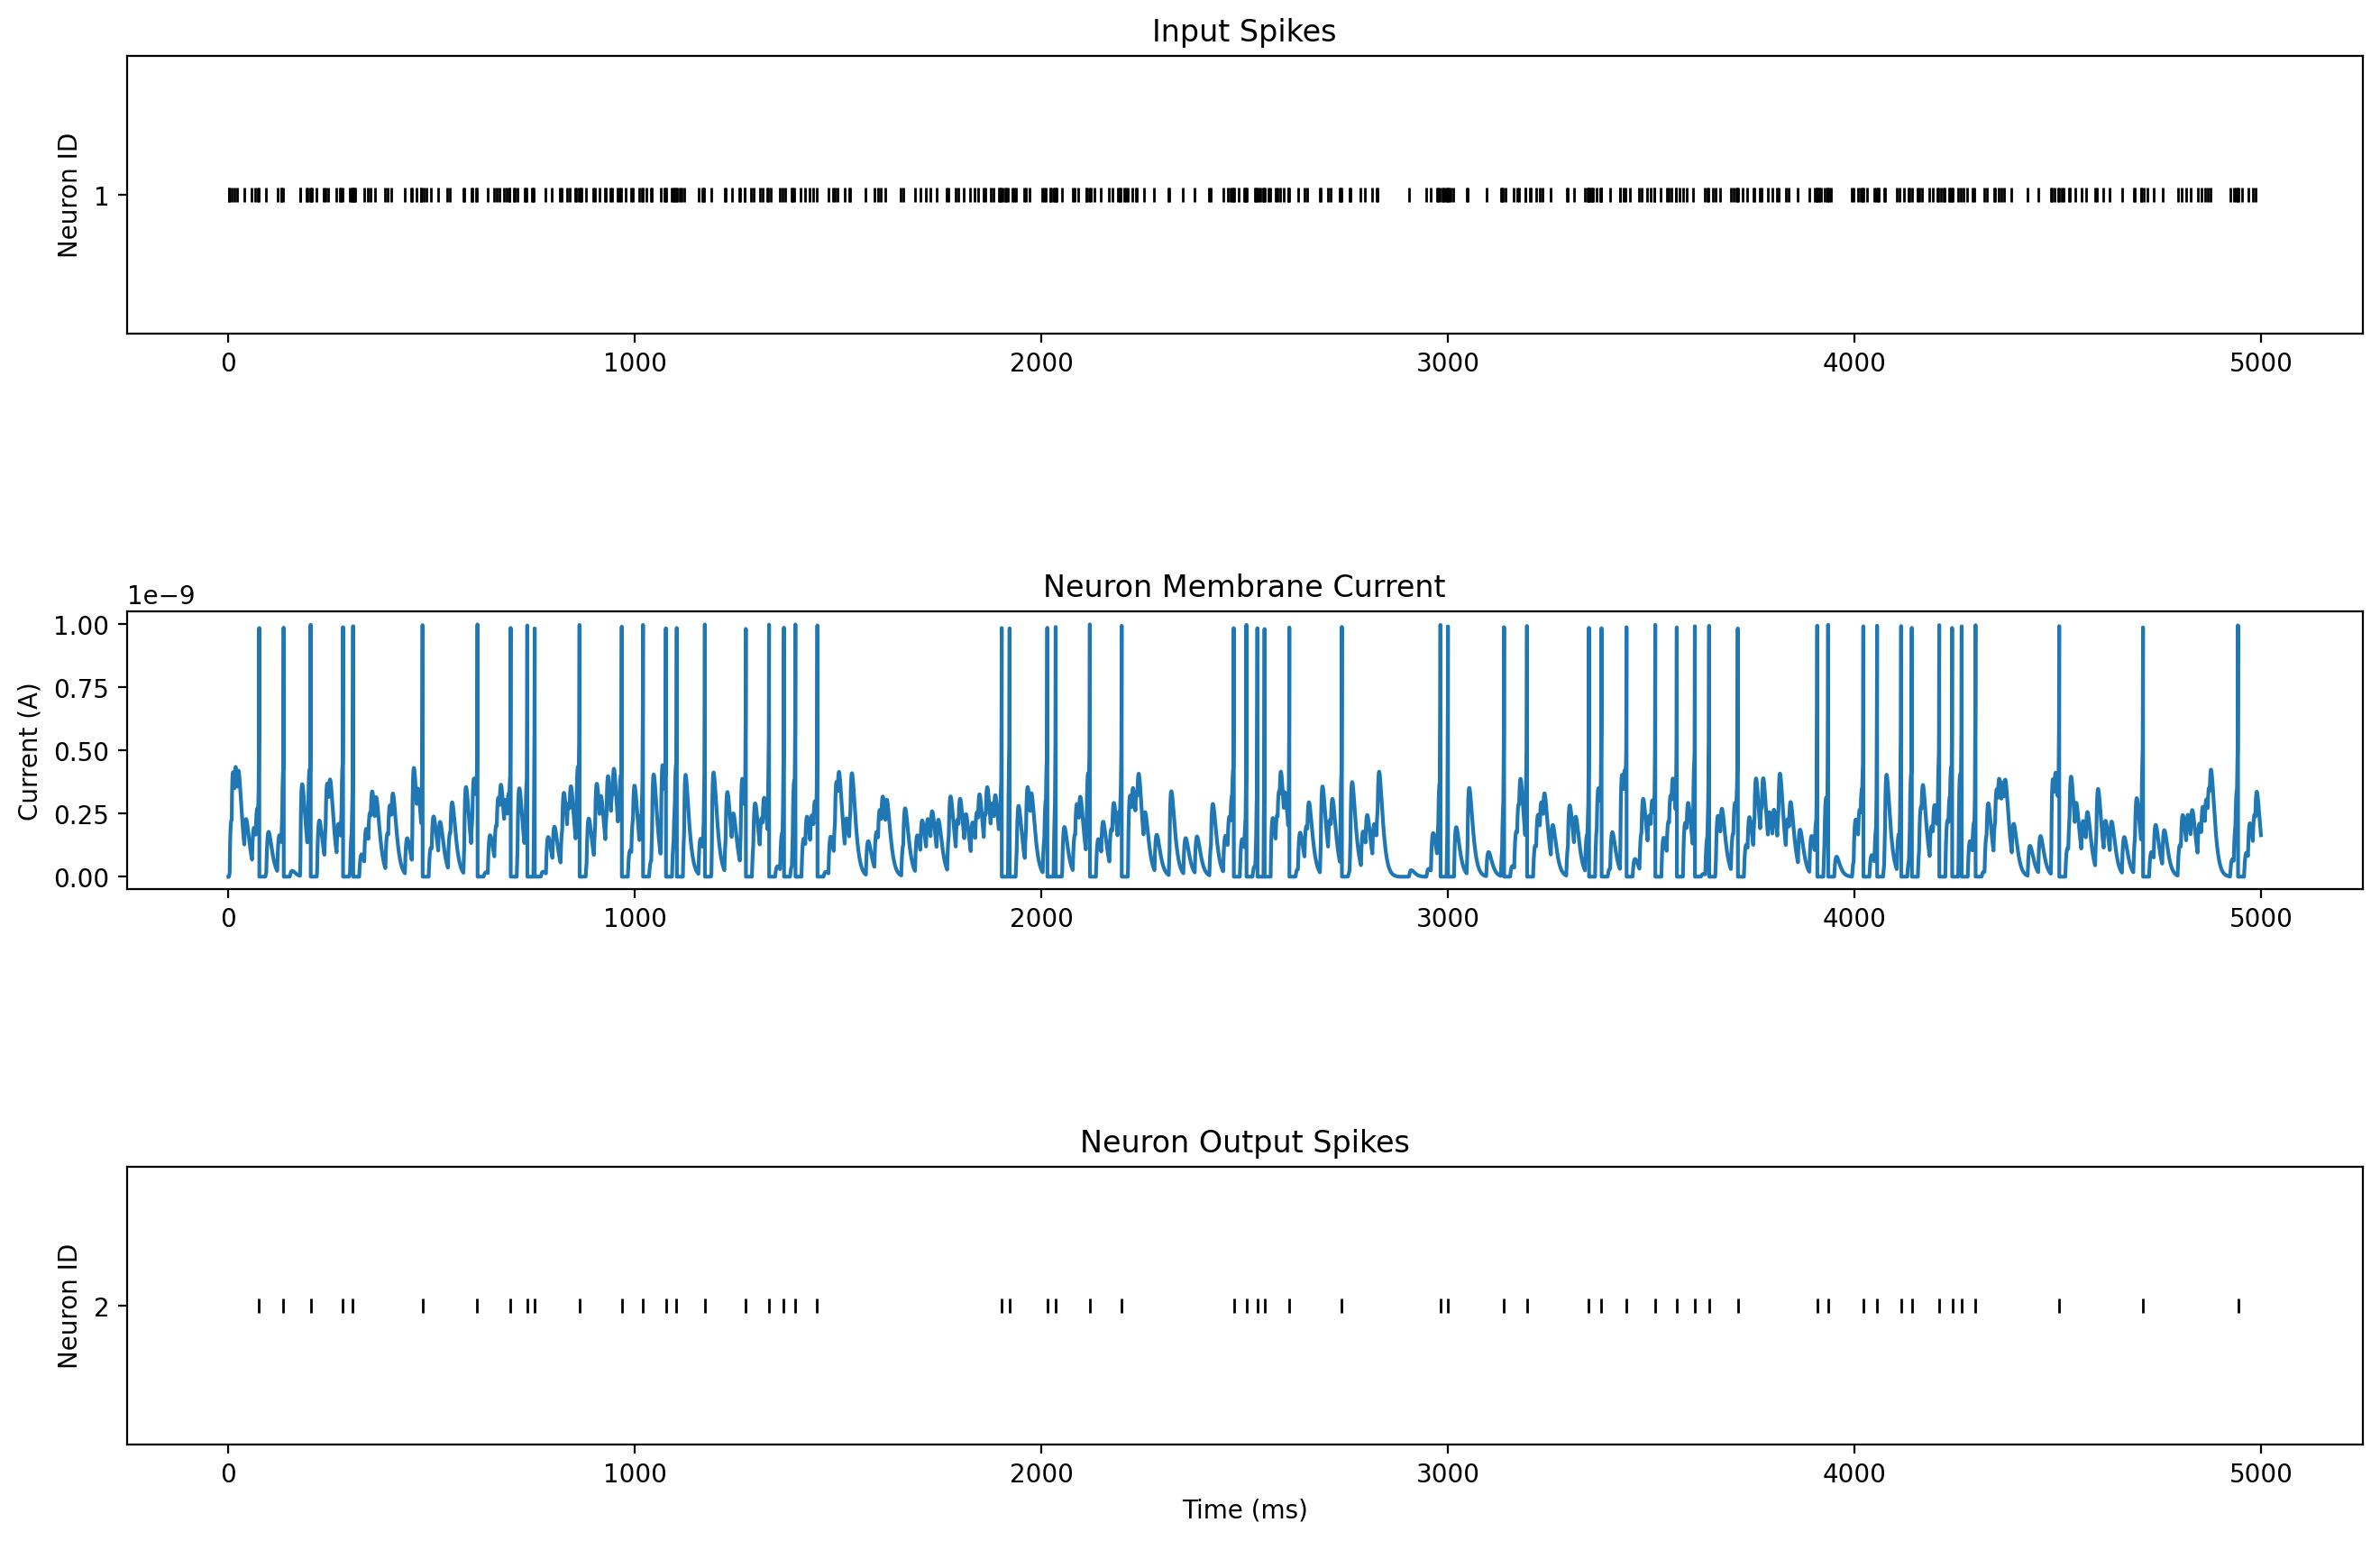

In [ ]:
plt.figure(figsize=(16,10),dpi=200)
plt.subplots_adjust(hspace=1)

# Input Spikes
plt.subplot(311)
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
plt.title('Input Spikes')
plt.ylabel('Neuron ID')
#plt.xlabel('Time (ms)')

plt.subplot(312)
Imemvec = mon_neuron_state.Imem[0]
plt.plot(mon_neuron_state.t/ms, Imemvec)

plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
#plt.xlabel('Time (ms)')

plt.subplot(313)
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_output.t/ms, dtype=int)]=2
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(1.5, 2.5)
plt.title('Neuron Output Spikes')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')
plt.show()

We provided an input spike train to a DPI neuron then observed some output spikes (If input spike parameters are correct). Now, we monitor the output current of DPI synapse that enters to neuron.

In [ ]:
def plot_ampa_nmda(tstart, tend):
  ##################
  #  TODO: Play with tstart and tend to locate synaptic currents. Try to estimate the time constant of the decay.
  #  Why do you think the amount of current at each input spike are not exactly same?
  #
  # Parameters
  # tstart = 2111 # ms
  # tend   = 2117 # ms
  ##################

  # Plotting
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(15, 8)
  fig.set_dpi(200)
  fig.suptitle('Synaptic Currents',y=1.02)
  s = int(1*ms / defaultclock.dt)

  # I_syn_ampa: synaptic current generated by an AMPA (α-amino-3-hydroxy-5-methyl-4-isoxazolepropionic acid) receptor-mediated synapse
  ax1.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_synapse_ampa.I_syn_ampa[0][tstart*s:tend*s], linewidth=1.5)
  ax1.legend(['AMPA'])
  ax1.set_ylabel('Current (A)')
  ax1.set_xlabel('Time (ms)')
  ax1.grid(True)
  ax2.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_synapse_nmda.I_syn_nmda[0][tstart*s:tend*s], linewidth=1.5)
  ax2.legend(['NMDA'])
  ax2.set_ylabel('Current (A)')
  ax2.set_xlabel('Time (ms)')
  ax2.grid(True)
  plt.tight_layout()

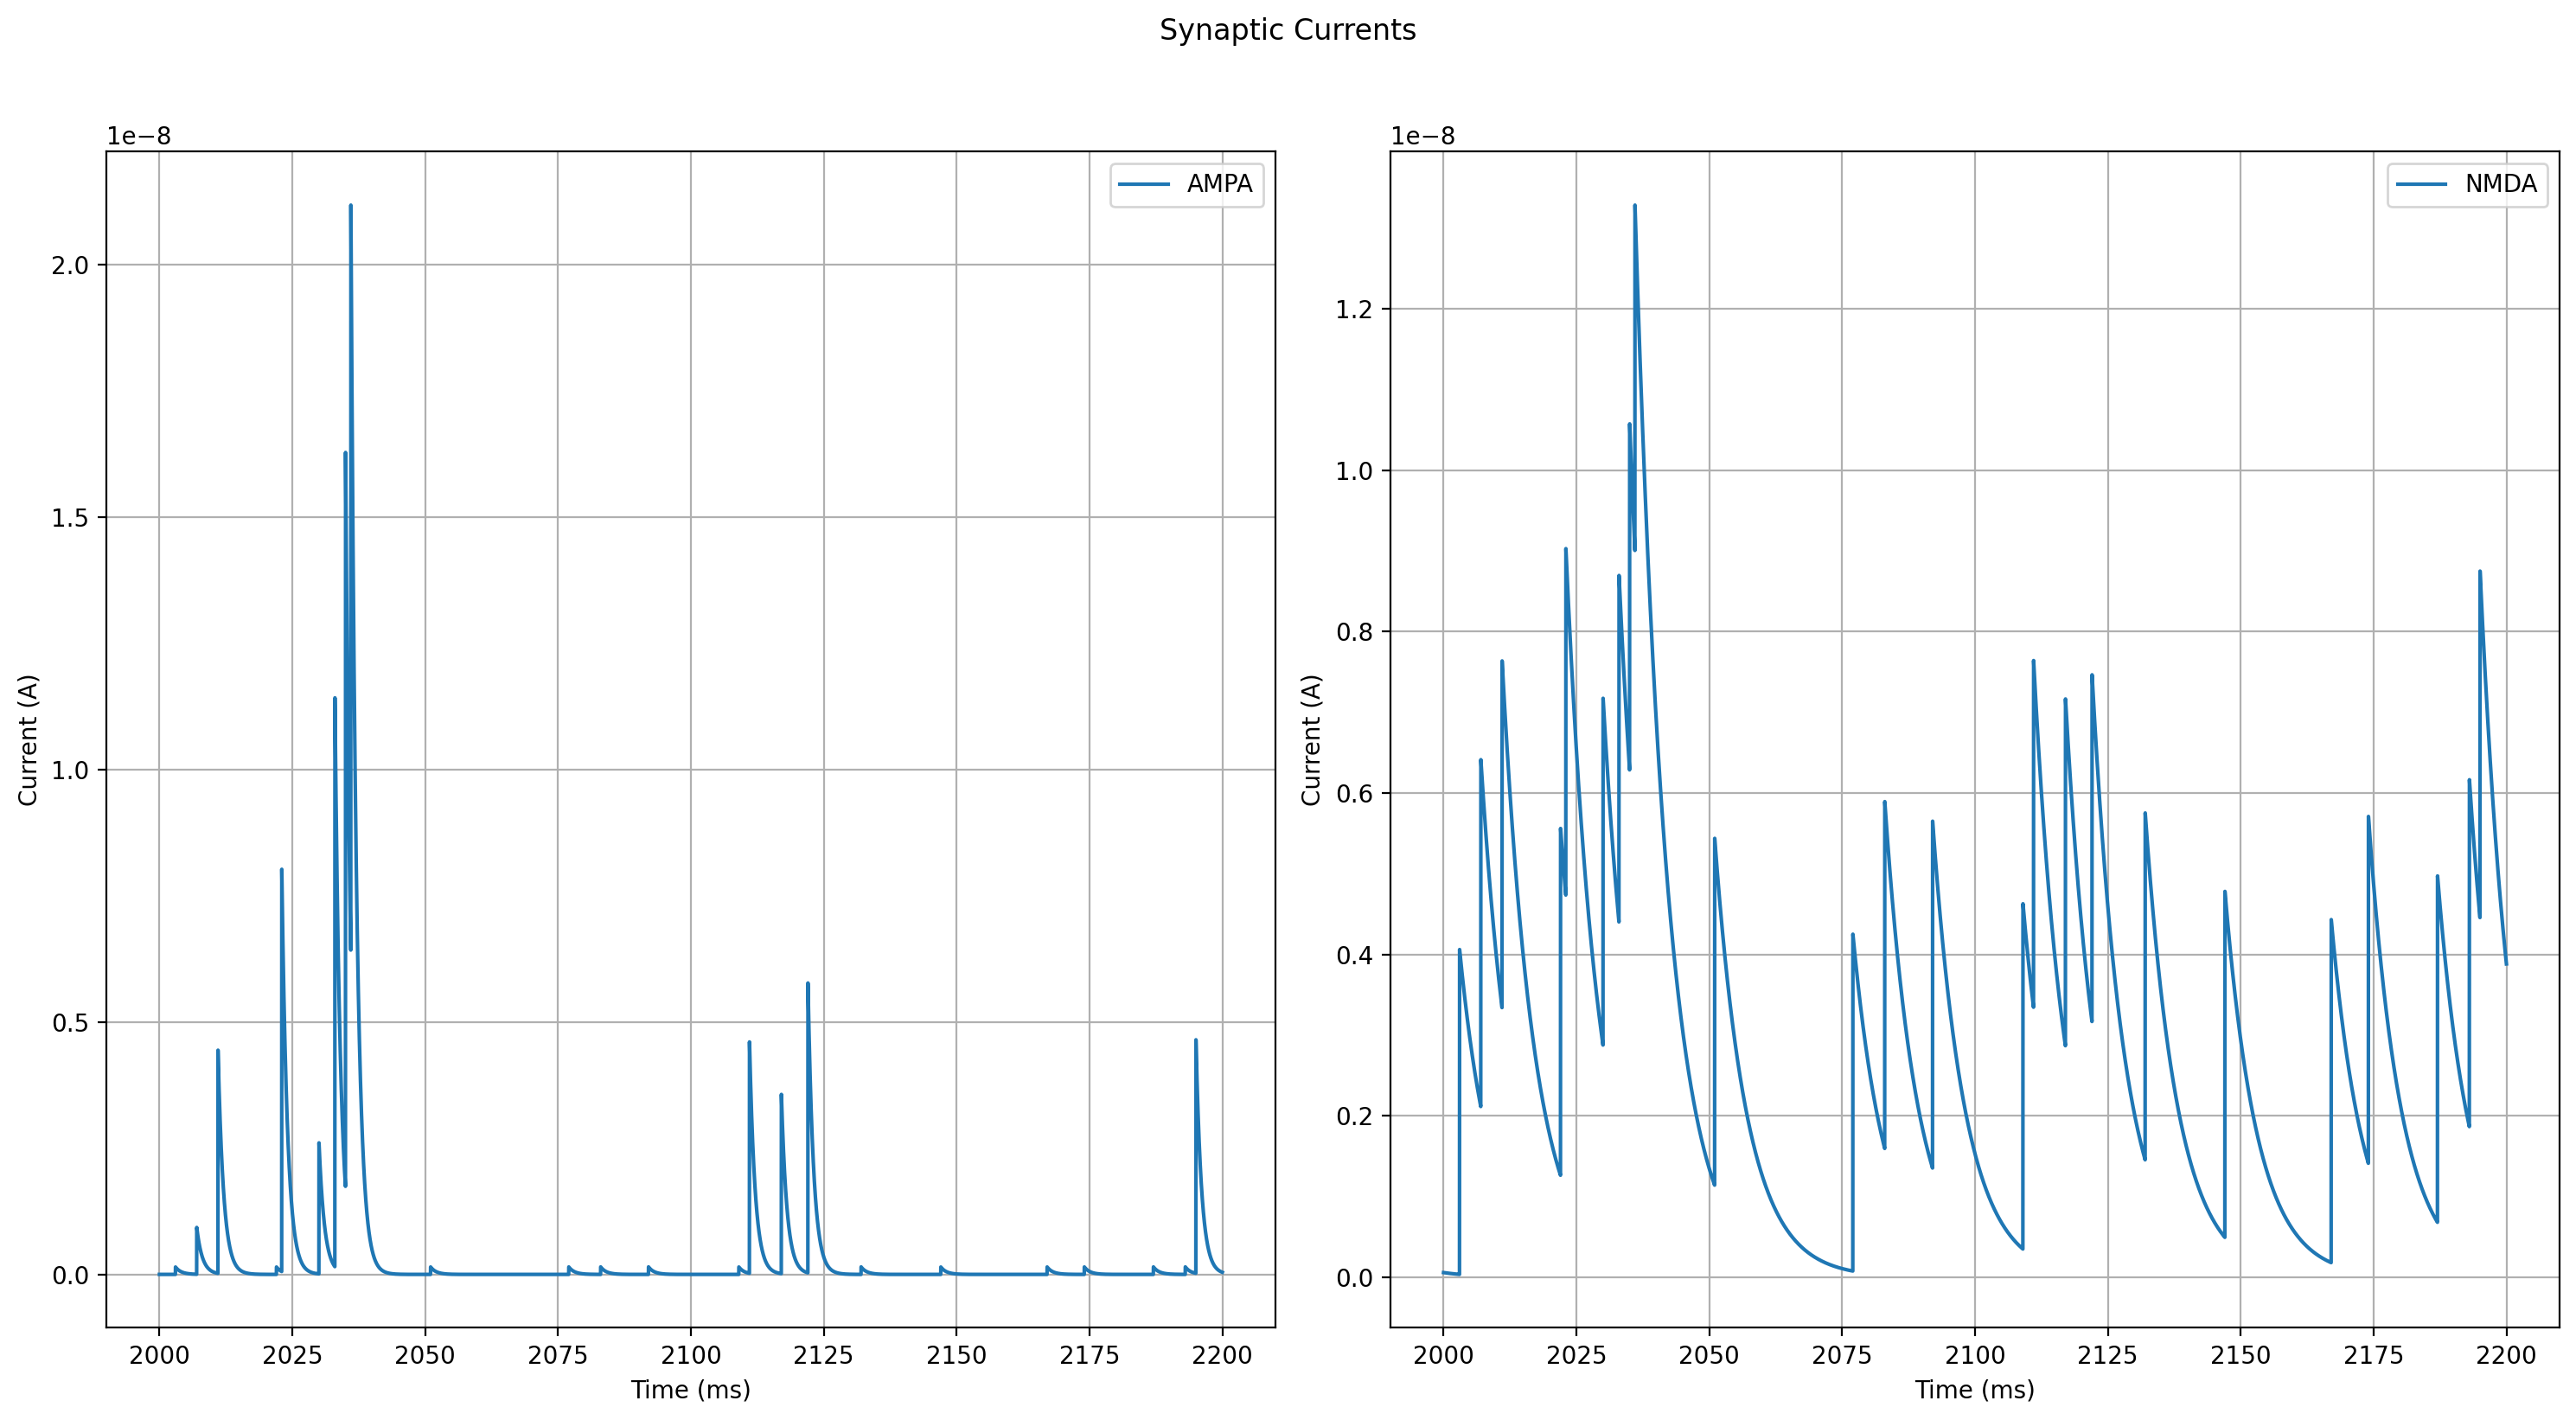

In [ ]:
plot_ampa_nmda(2000, 2200)

# Play with tstart and tend to locate synaptic currents. Try to estimate the time constant of the decay.

## Time constant for AMPA

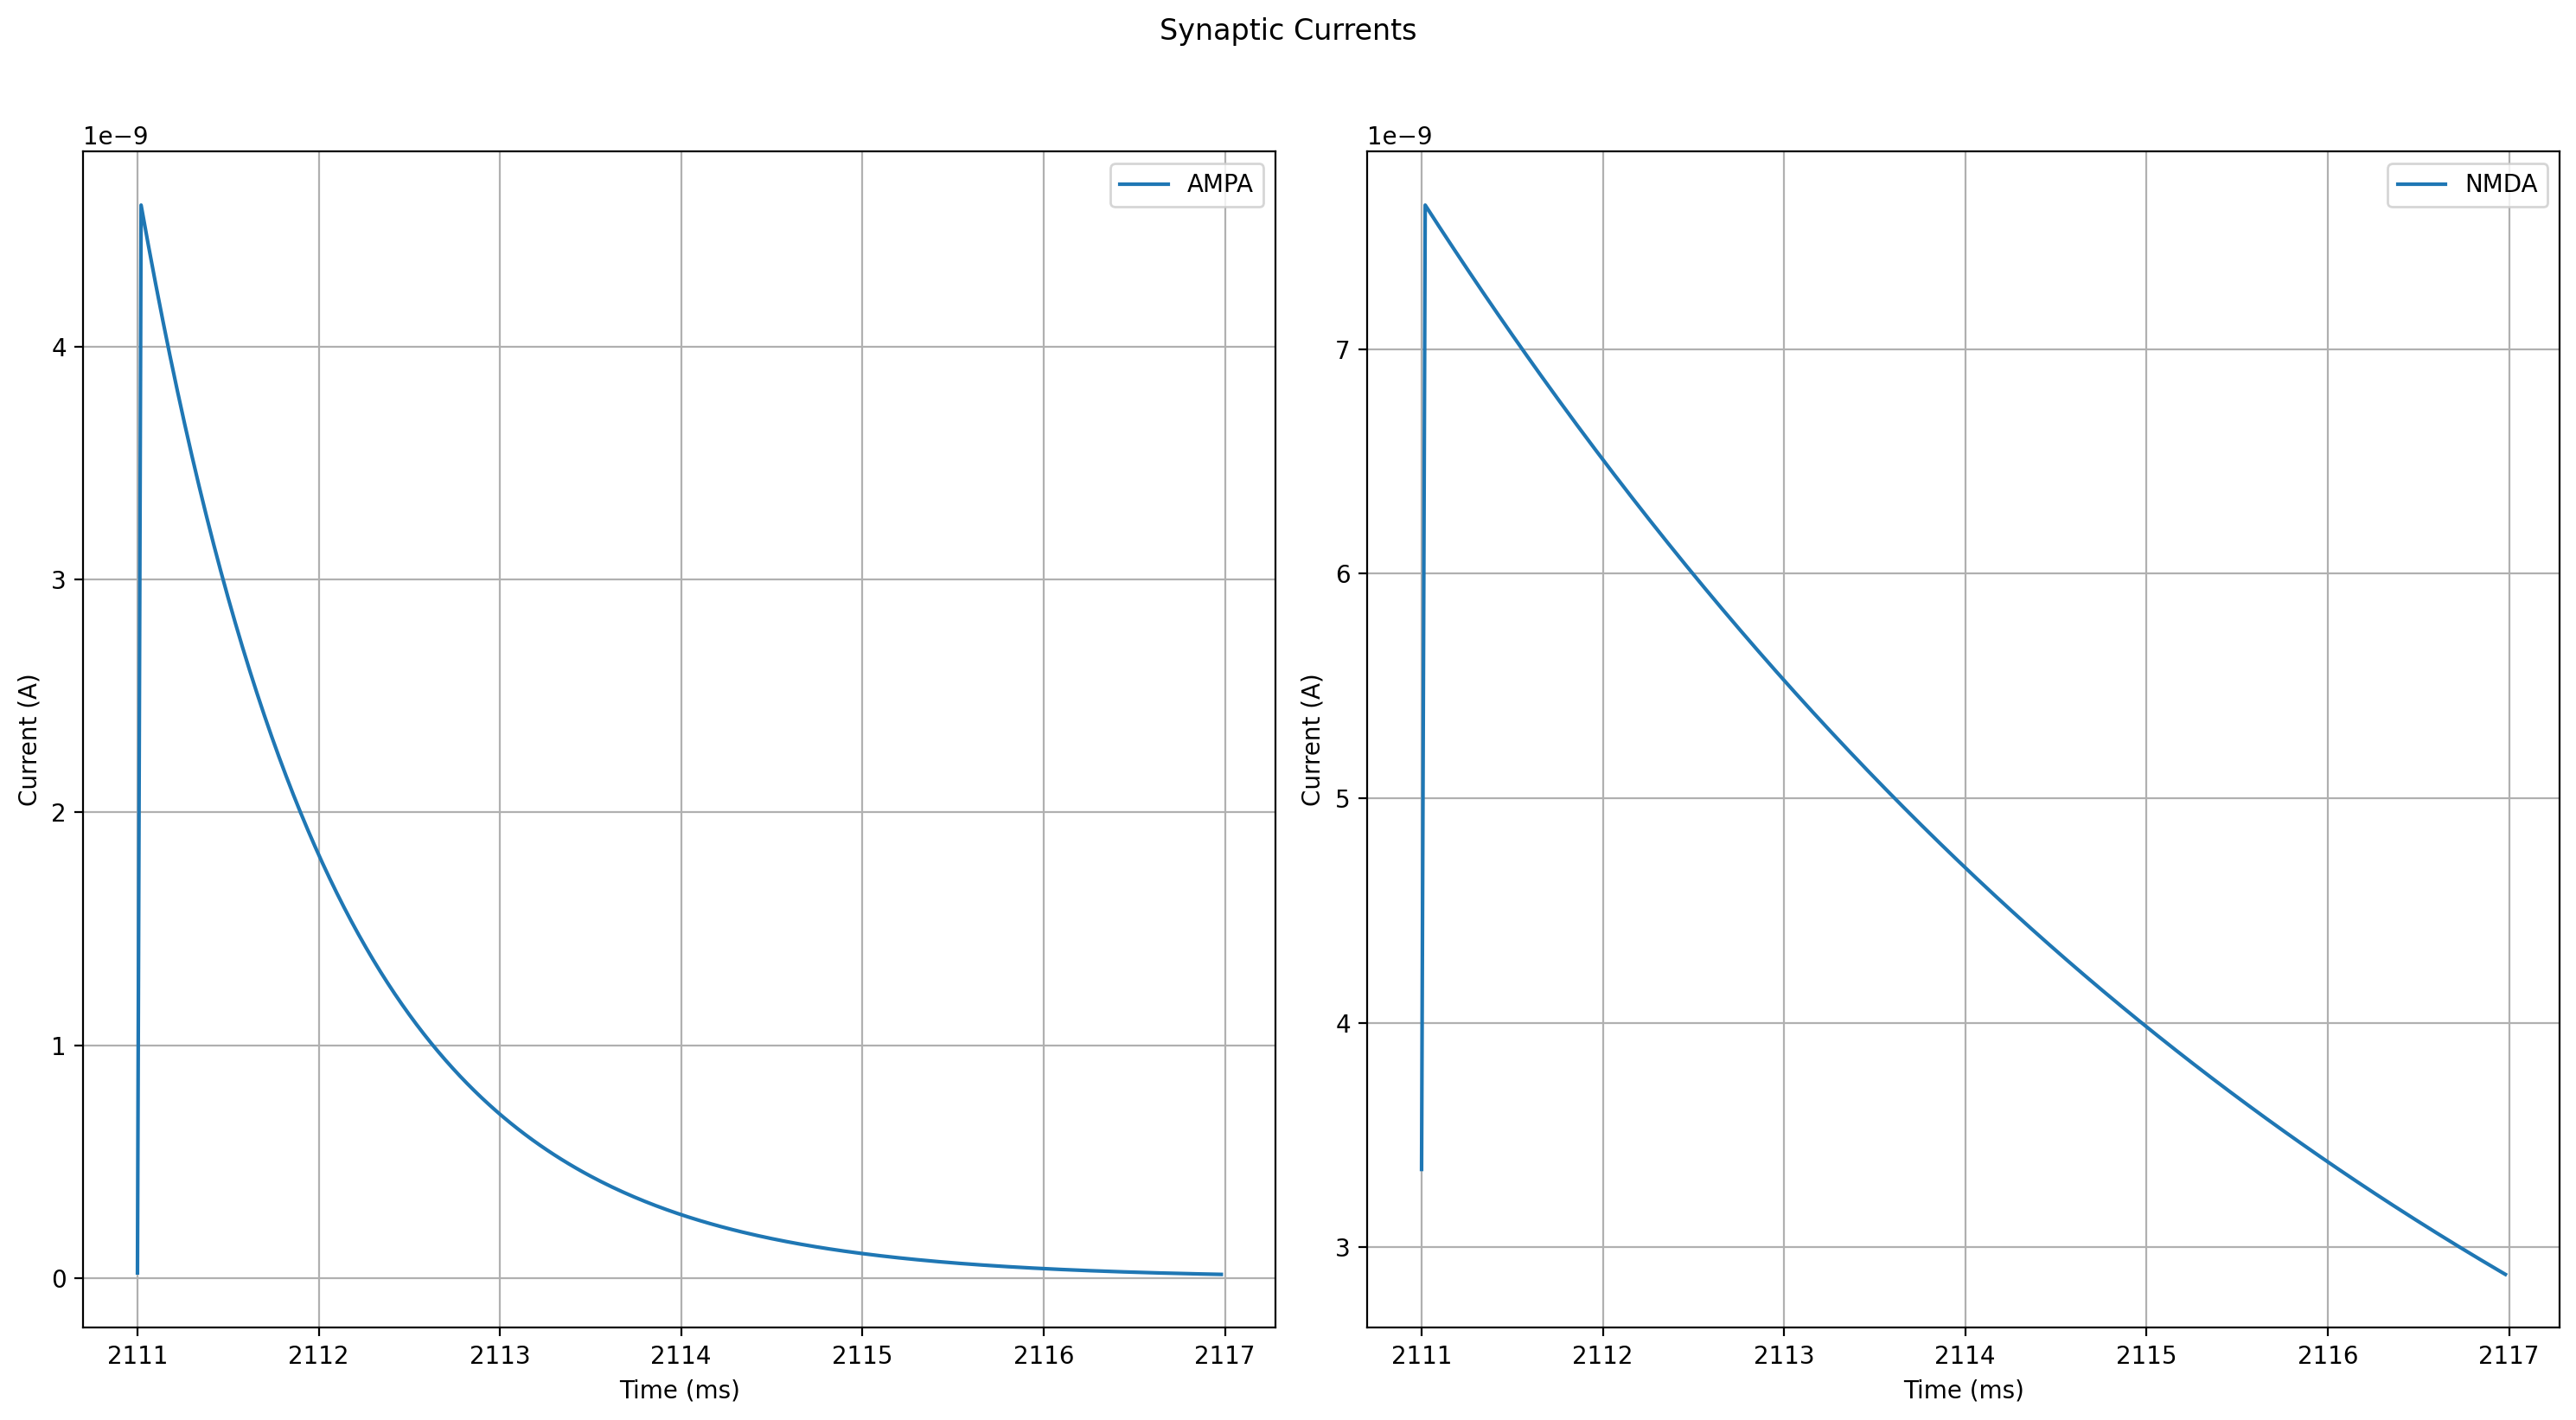

In [ ]:
plot_ampa_nmda(2111, 2117)

In [ ]:
mon_synapse_ampa.I_syn_ampa[0][2111*s+1], mon_synapse_ampa.I_syn_ampa[0][2117*s]

(4.60649408 * namp, 15.80792397 * pamp)

### Answer:
From https://en.wikipedia.org/wiki/Time_constant: after five time constants the function reaches a value less than 1% of its original. In most cases this 1% threshold is considered sufficient to assume that the function has decayed to zero – as a rule of thumb
So tau_ampa can be estimated as 6ms/5 = 1.2ms


## Time Constant for NMDA

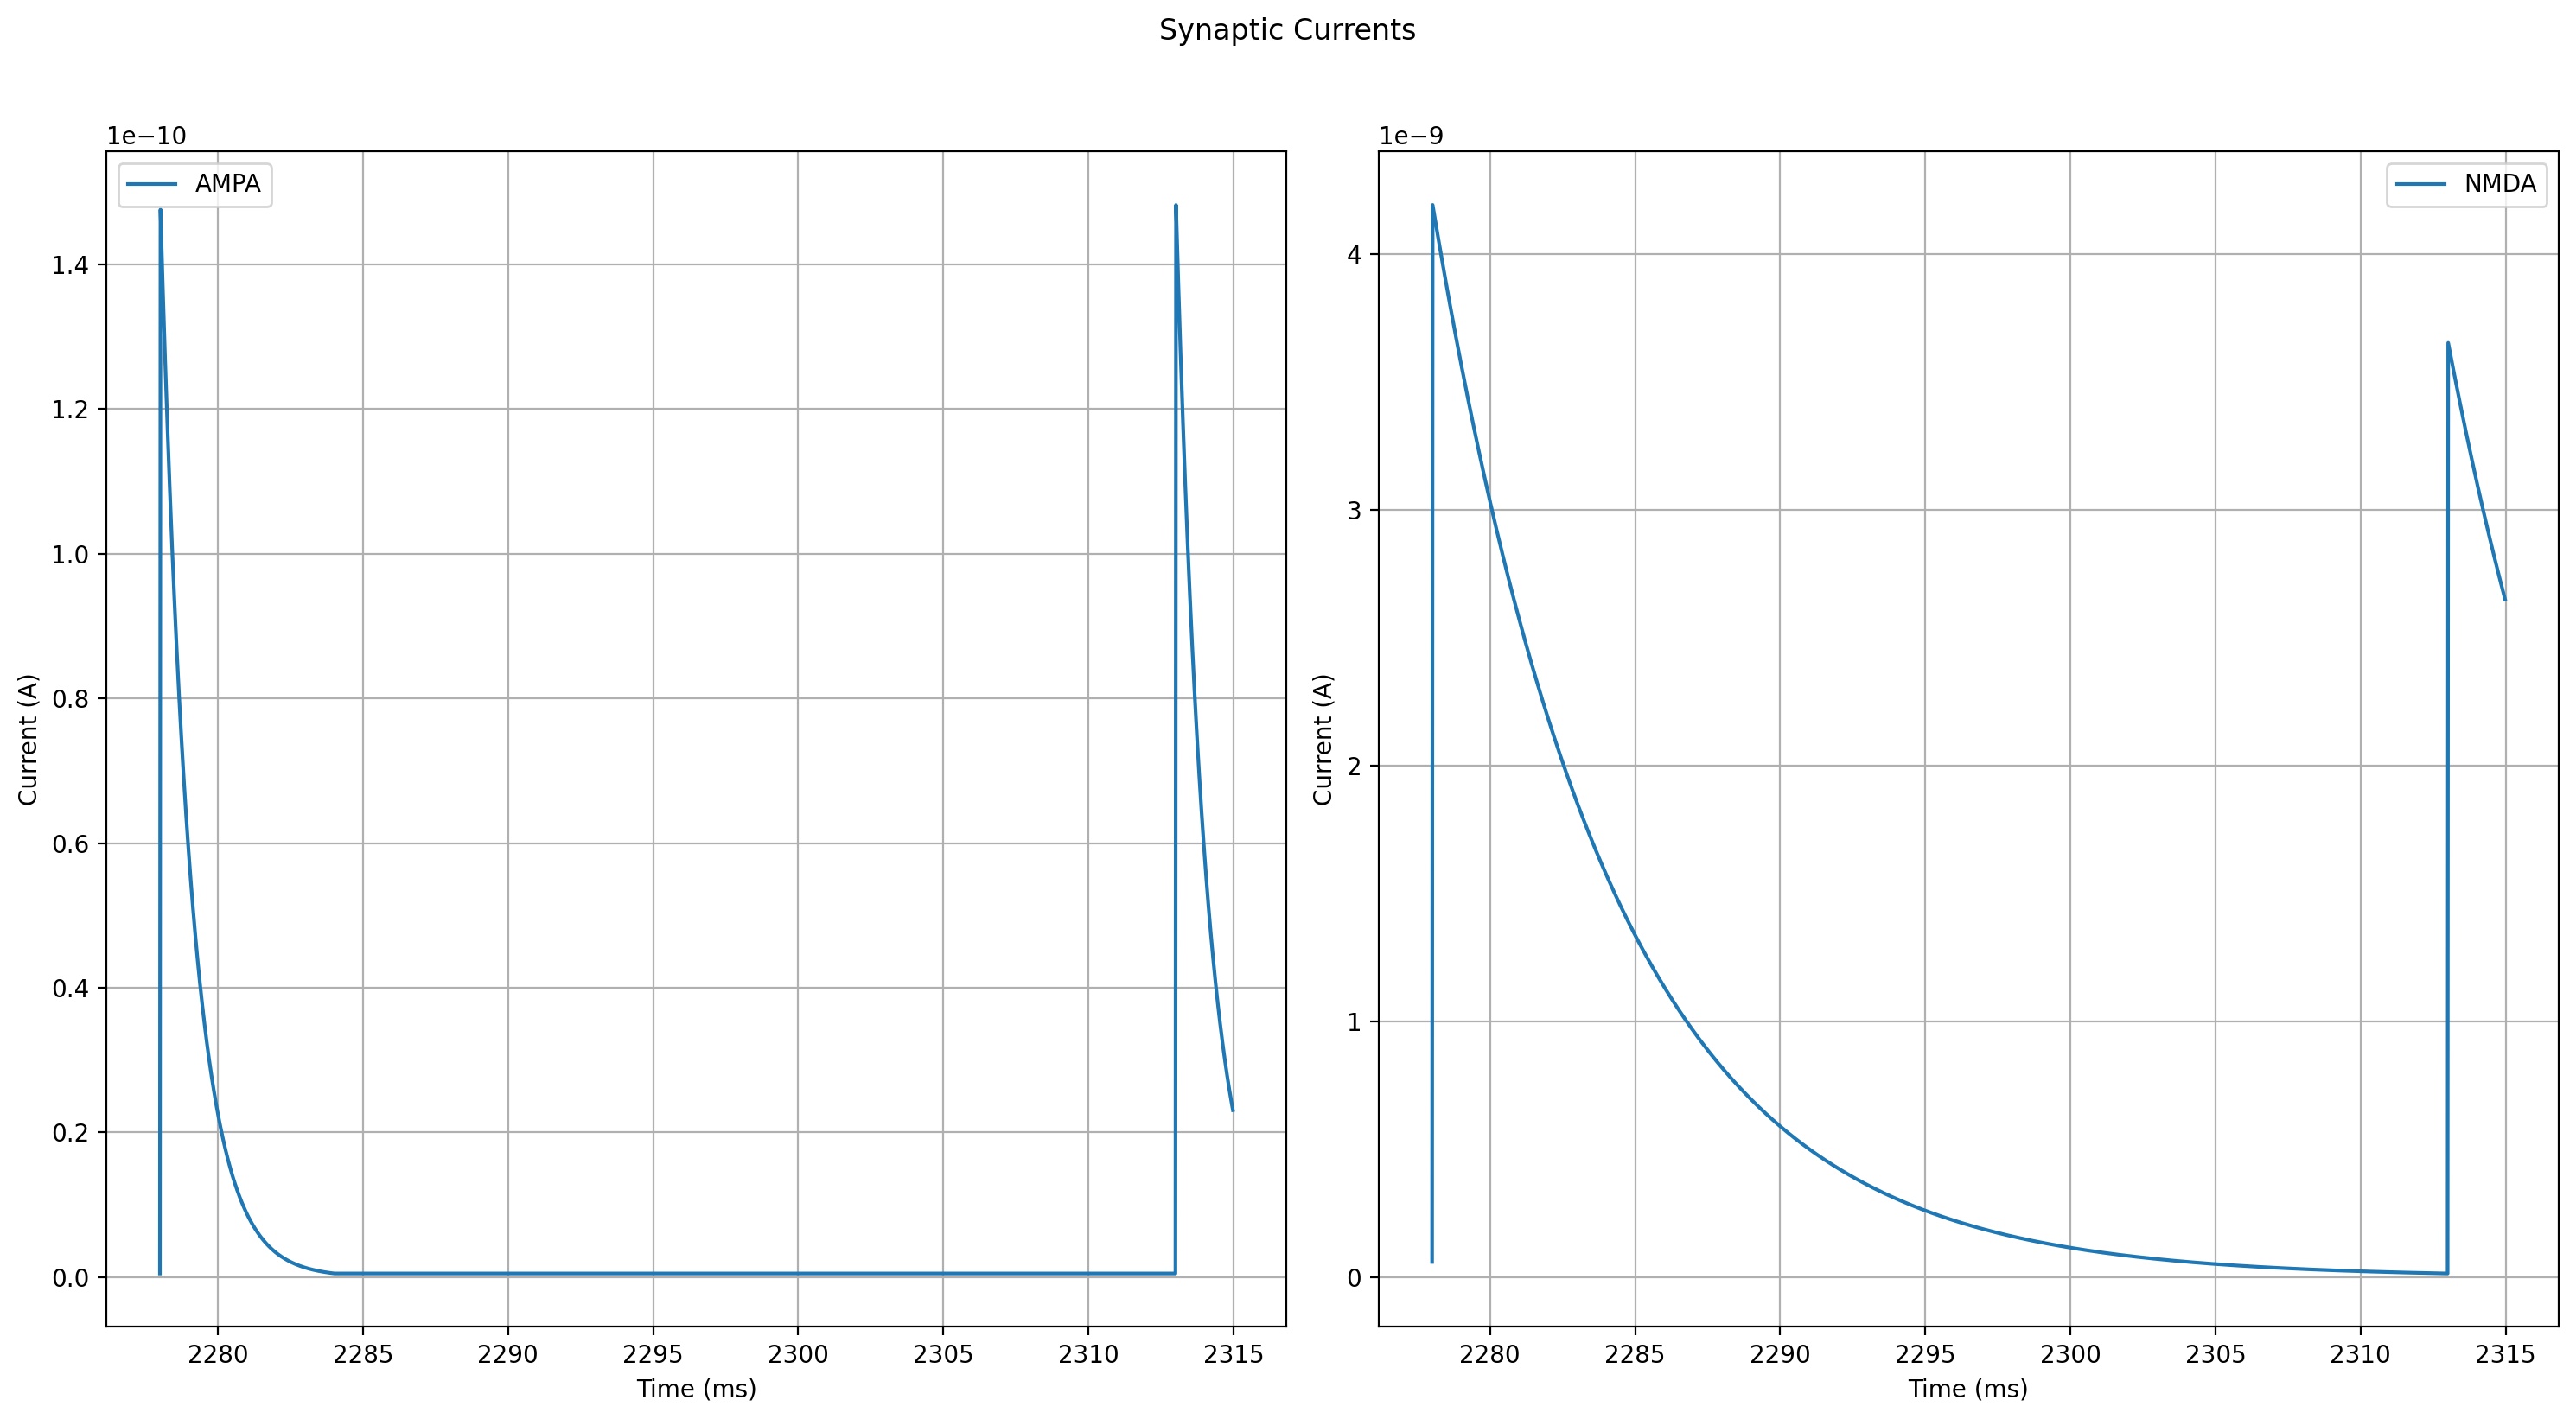

In [ ]:
plot_ampa_nmda(2278, 2315)

In [ ]:
mon_synapse_nmda.I_syn_nmda[0][2278*s+1]

4.19210258 * namp

In [ ]:
mon_synapse_nmda.I_syn_nmda[0][2278*s+1]*0.37

1.55107795 * namp

In [ ]:
mon_synapse_nmda.I_syn_nmda[0][2284*s]

1.57382719 * namp

### Answer:
After a period of one time constant the function reaches e−1 = approximately 37% of its initial value. So tau_nmpa can be estimated as 6ms.

## Why do you think the amount of current at each input spike are not exactly same?
Let's take a close look at the input spike train and the output current of DPI synapse that enters to neuron, for example during 2000 ms to 2100 ms:

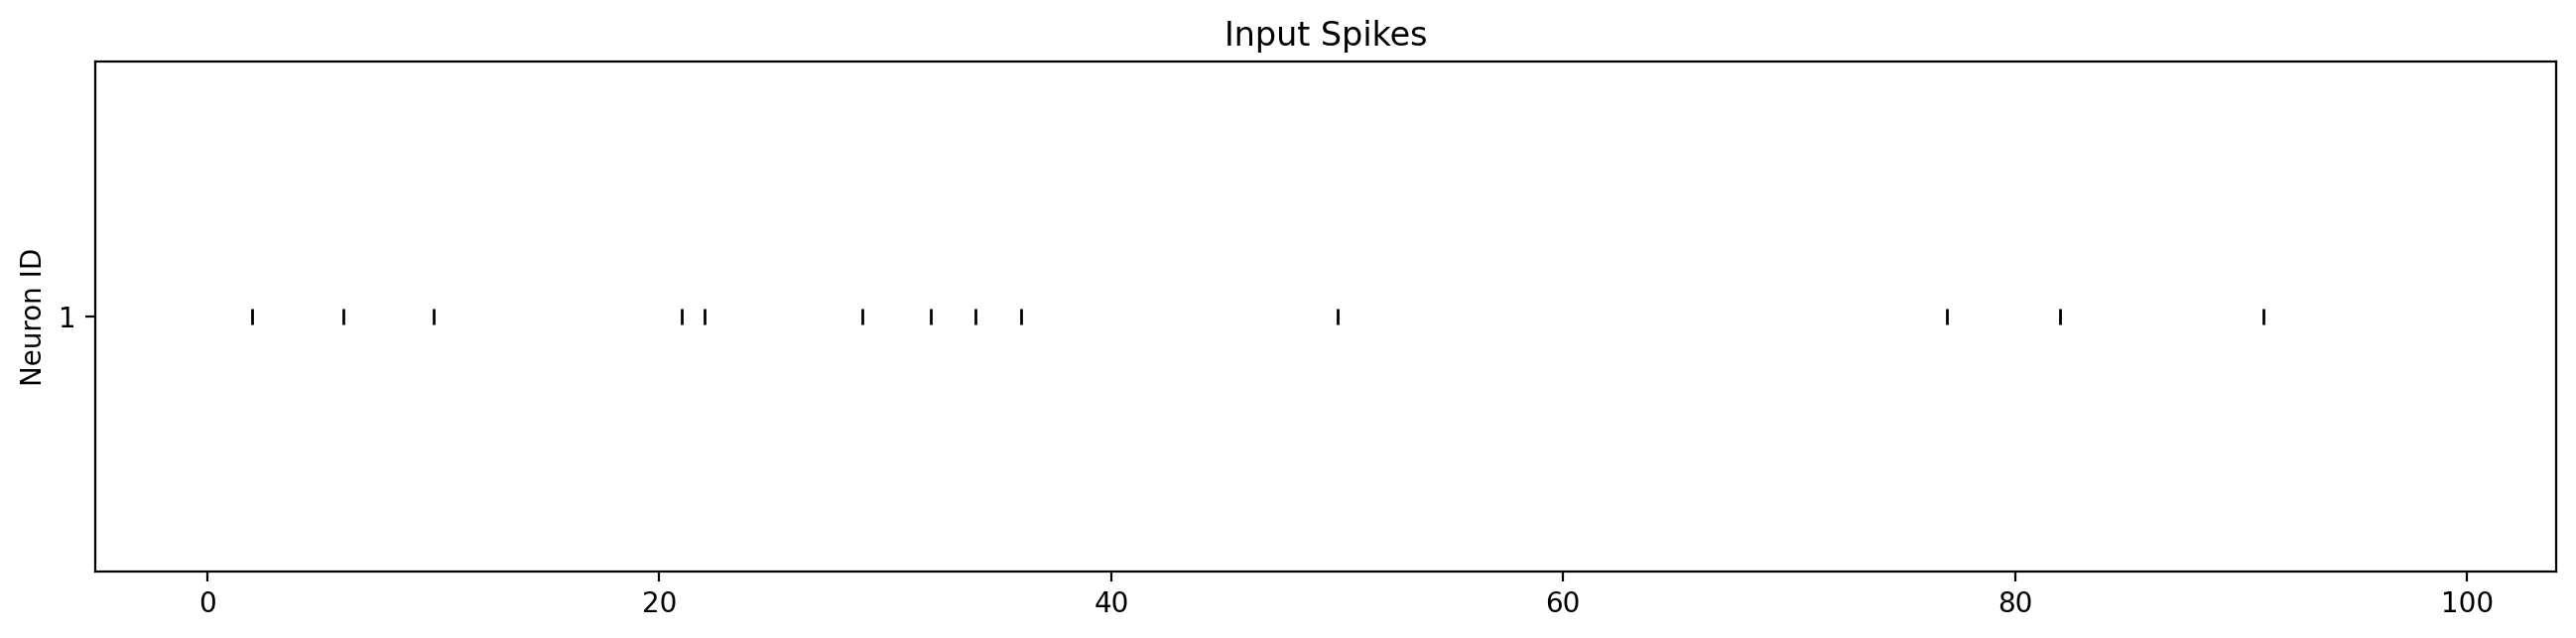

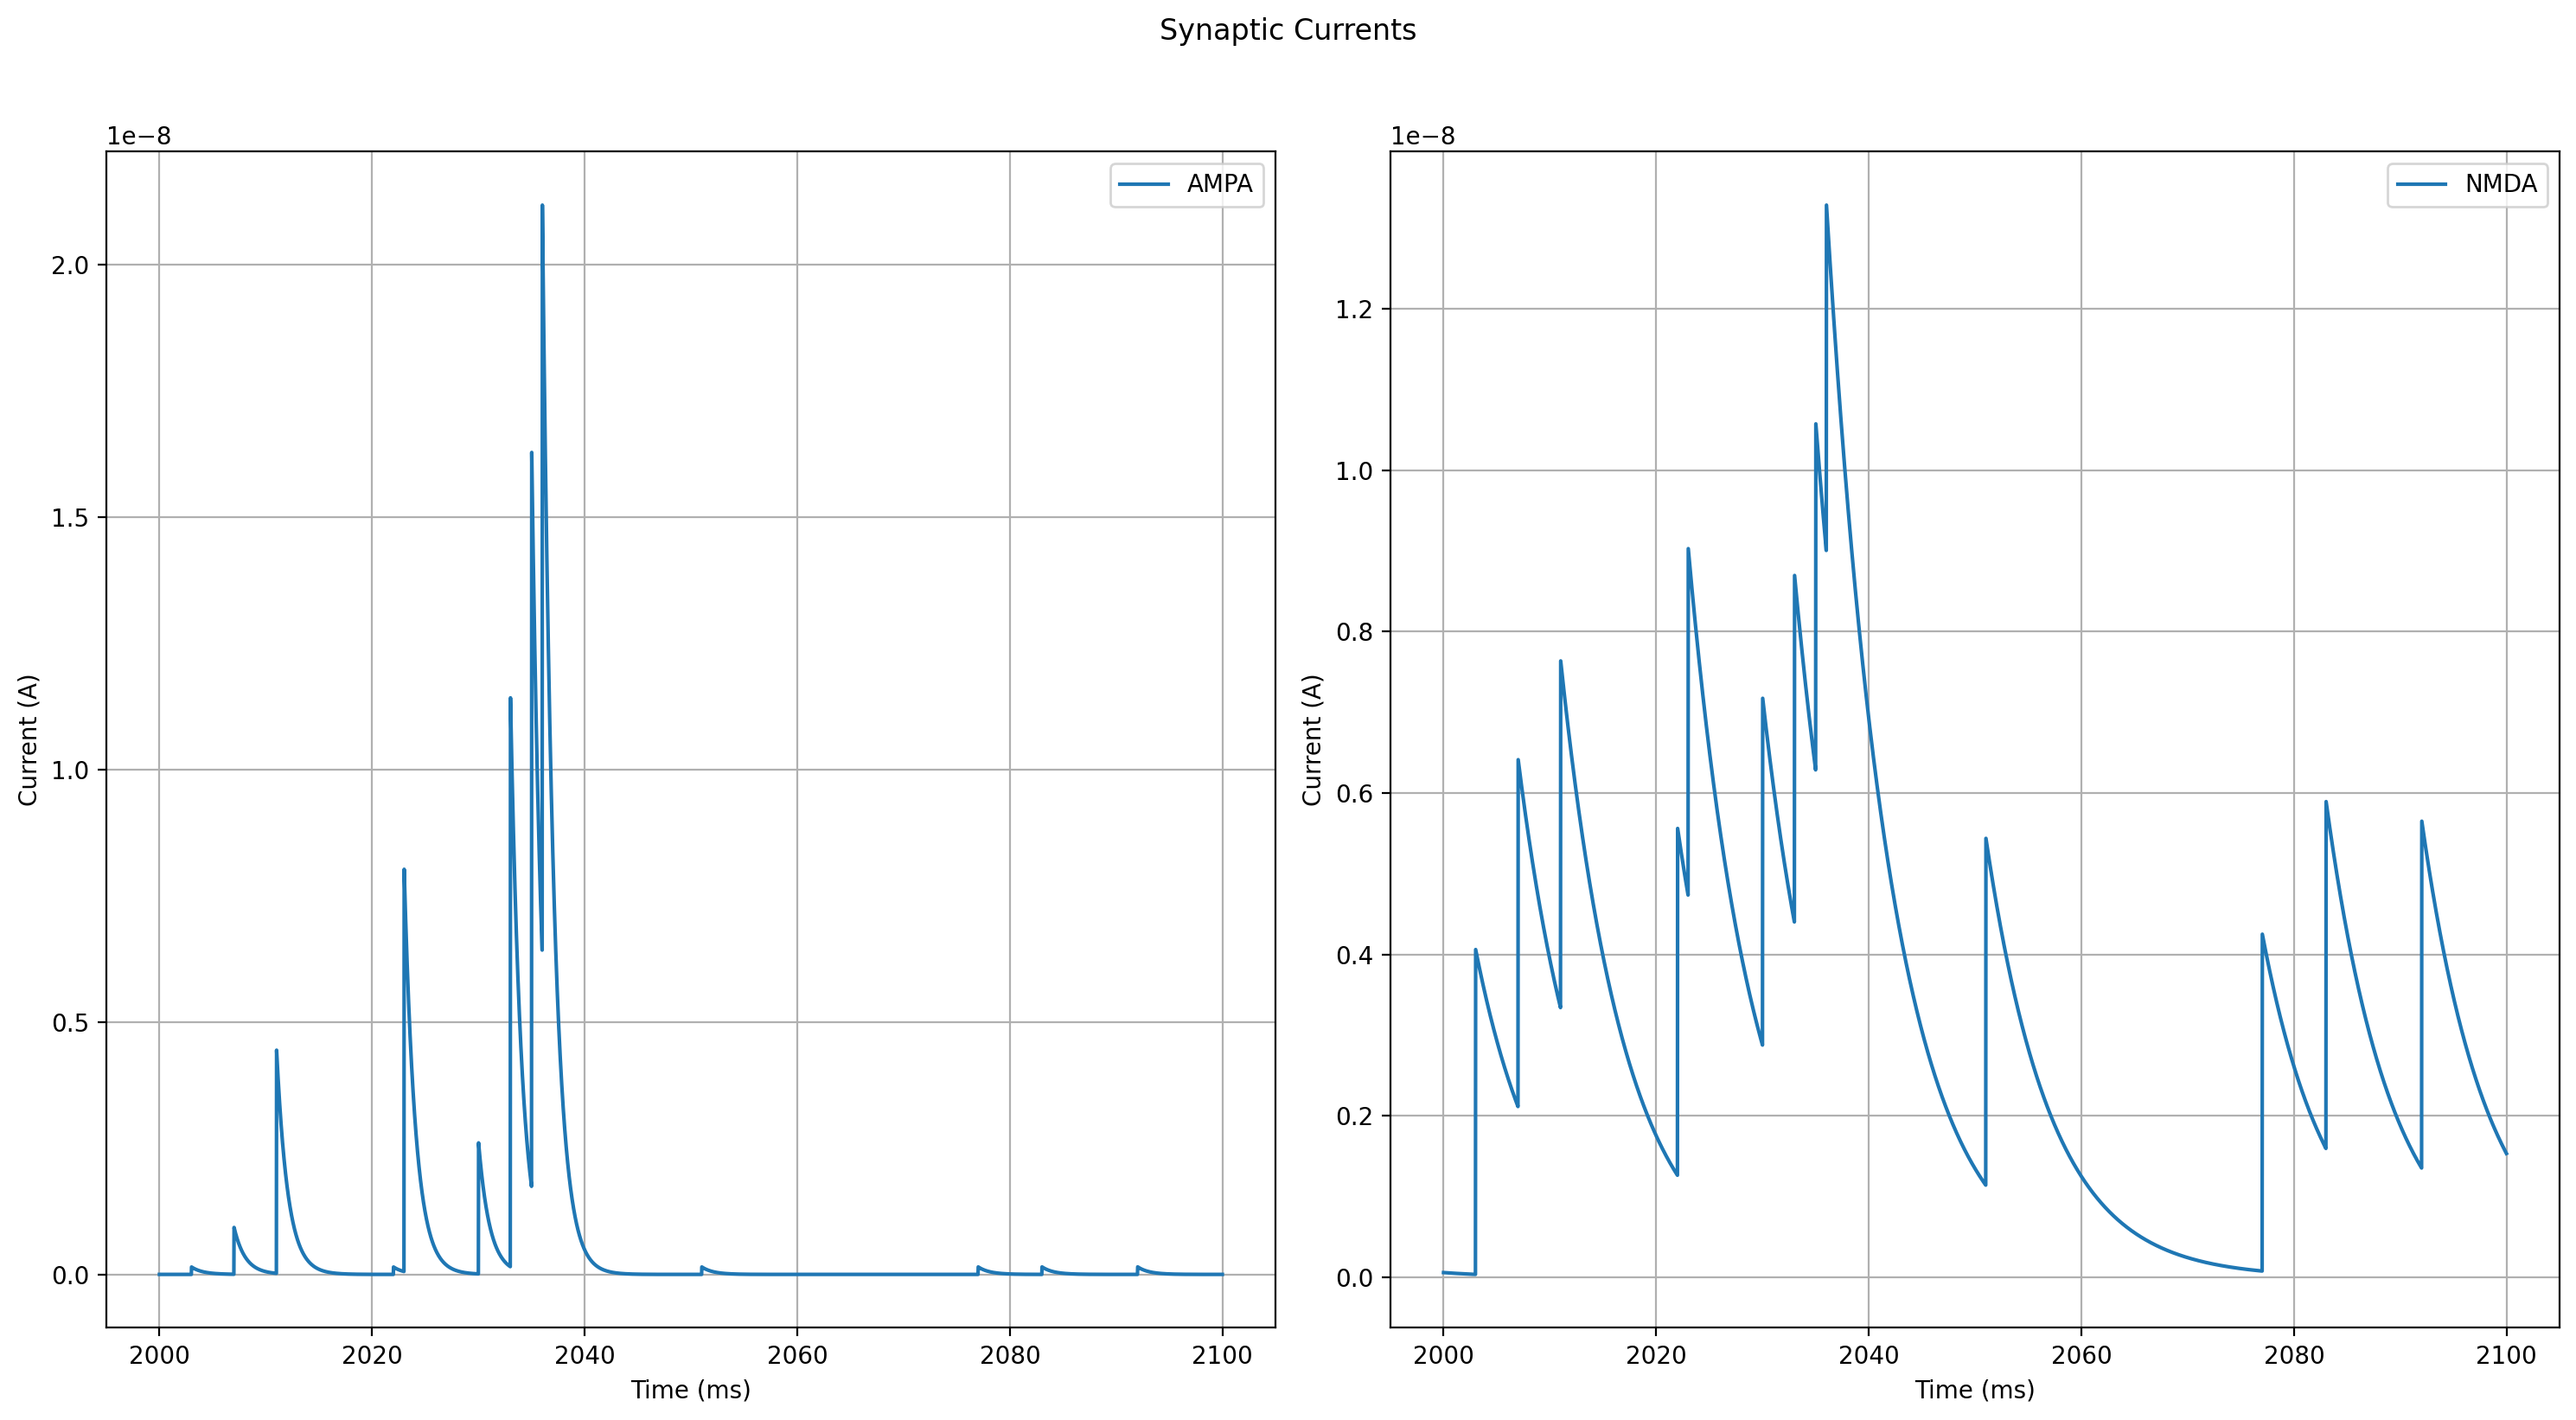

In [ ]:
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=1
plt.figure(figsize=(16,10),dpi=200)
plt.subplots_adjust(hspace=1)

# Input Spikes
plt.subplot(211)
sub_spike = spike_placeholder[2000:2100]
plt.plot(sub_spike,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
plt.title('Input Spikes')
plt.ylabel('Neuron ID')

# DPI Synapse Spikes
plot_ampa_nmda(2000, 2100)

### Answer
1. The DPI synapse spike current amplitude increases when there is continuous input spike during a period of time
1. The DPI synapse spike current returns to lowest level when there is no input spike for a period of time

Finally, we can observe the membrane current ($I_{mem}$) on silicon neuron and see how synaptic input accumulates and results in spikes.

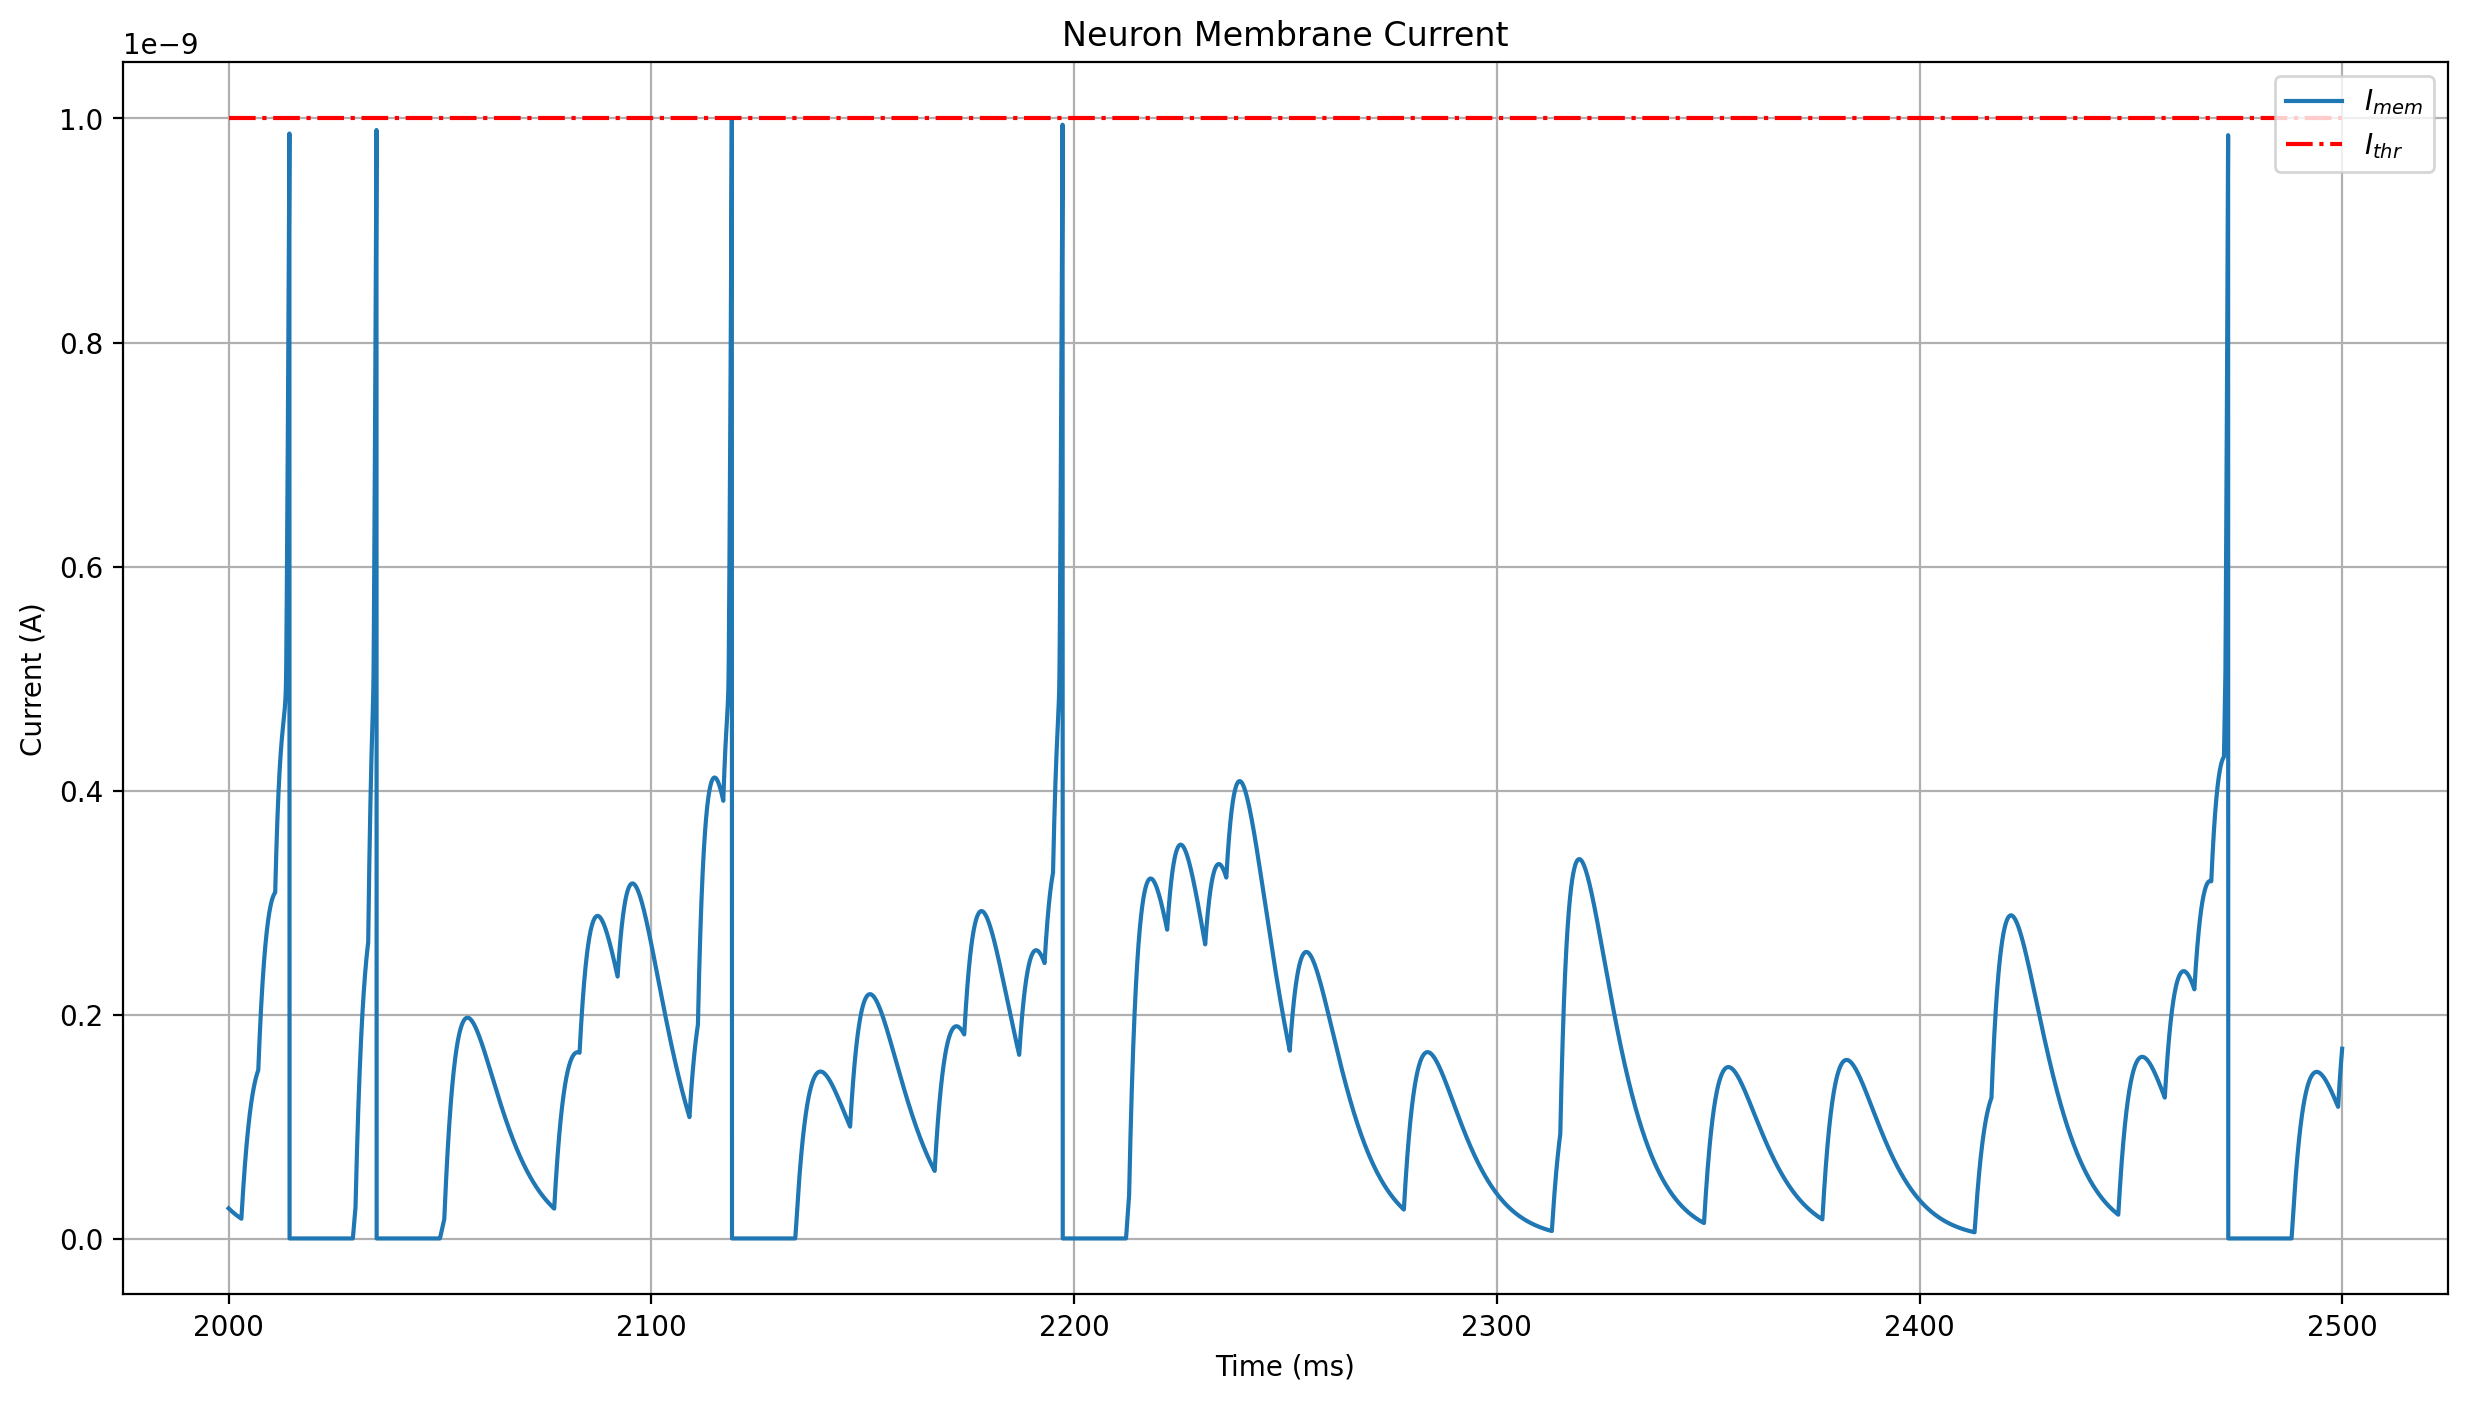

In [ ]:
##################
#  TODO: Play with tstart and tend to observe membrane current fluctuations and the moments of spike output.
#        Notice that the membrane current is more smoother than its synaptic input.
#
# Parameters
tstart = 2000 # ms
tend   = 2500 # ms
##################

### The membrane potential is the result of the integration of all incoming synaptic currents
### It tends to smooth out rapid fluctuations.
# Plotting
s = int(1*ms / defaultclock.dt)
plt.figure(figsize=(15,8),dpi=200)
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_neuron_state.Imem[0][tstart*s:tend*s], linewidth=1.5)
plt.hlines(y=dynapse_param['Ispkthr']*1e-9/nA, xmin=tstart, xmax=tend, color='r', linestyles='-.')
plt.legend(['$I_{mem}$', '$I_{thr}$'])
plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
plt.xlabel('Time (ms)')
plt.grid(True)

This is the end of Part 1.

---

Some notes:

The synaptic current I_syn_ampa contributes to the total membrane current Imem. When a synaptic event occurs and AMPA receptors are activated, the resulting synaptic current will be part of the total current measured in Imem.

Capacitance: The neuron's membrane has capacitance, which means it can store and release electrical charge. This property causes the membrane to integrate incoming synaptic currents over time rather than responding instantaneously.

Resistance: The membrane also has resistance, which influences how quickly the membrane potential can change. The combination of capacitance and resistance creates an RC circuit, which behaves like a low-pass filter.

# Part 2: Calculating the F-F curve of the AdEx neurons in DYNAP-SE

In the second part, we will calculate the F-F curve of silicon neurons (similarly to the I-F curve that you calculated in Exercise 0). In neuroscience, the F-F curve is a function that relates to the input firing rate and the output firing rate of a neuron. Because the F-F curve only specifies the firing rate rather than exact spike times, it is a concept suited to the rate coding rather than the temporal coding model of neuronal computation. To obtain the F-F curve, we will simulate silicon neurons with a range of spike frequencies and observe the output behavior.

There are multiple ways to create spike trains of different frequencies and stimulate neurons. One way is to stimulate single neuron with a fixed frequency and loop over a set of frequencies. Alternatively, we can stimulate multiple neurons, each with unique frequency in parallel. The latter is more compute-efficient on Brian2, and this is what we are going to implement.

In [ ]:
## Calculating the F-F curve of DPI neurons
##################
# TODO:
# - Play with frequency range and the simulation duration
#
# Parameters
inp_duration   = 5     # second - Simulation duration (default: 5)
freq_start     = 0     # Hz - Starting frequency (Neuron 0 will be stimulated with this Poisson rate) (default: 0)
freq_stop      = 200   # Hz - Stop frequency (The last neuron will be stimulated with this Poisson rate) (default: 200)
num_neurons    = 200
##################

# Re-initialize the device
device.reinit()
device.activate()
defaultclock.dt = 20 * us
# Ignore Brian2 base warnings
BrianLogger.suppress_name('base')

# Create a Brian2 network and chip instance using that monitors Dynap-SE1 resources.
network = Network()
chip = DynapSE(network)

To simulate neurons, we will use Poisson spikes. For stimulating $N$ neurons, we require $N$ different Poisson rates. To achieve that, we create a matrix with dimensions [simulation time steps, source ID], where the source ID represents the firing rate, e.g., source 5 will fire at 5 Hz, source 20 at 20 Hz, etc.

Then we will create our network on Brian2, similar to Part 1, except for one single difference. This time, we will connect single sources to single corresponding neurons (one-to-one instead of all-to-all). To achieve that, we use `DPI_synapse.connect(j='i')`. As in Part 1 the execution time of the next cell depends on the compiler settings and computer and may take up to several minutes.

In [ ]:
# Create [time_steps, source ID] matrix, where firing rate is defined by source ID.
# e.g., source 5 will fire at 5 Hz.
# rates2 = np.tile(np.linspace(freq_start, freq_stop, freq_stop-freq_start), (inp_duration*1000, 1)) # shape: (inp_duration*1000, 256)
rates2 = np.tile(np.linspace(freq_start, freq_stop, num_neurons), (inp_duration*1000, 1)) # shape: (inp_duration*1000, 256)

# Create a TimedArray according to rate information
spike_timing = TimedArray(rates2 * Hz , dt=1 * us)

# Using spike timing function, generate a Spike Generator that creates Poisson spikes
# input_spike_generator = PoissonGroup(freq_stop-freq_start, "spike_timing(t,i)")
input_spike_generator = PoissonGroup(num_neurons, "spike_timing(t,i)")

# Allocate neurons such that each firing frequency will be assigned to single neuron.
# DPI_neuron  = chip.get_neurons(freq_stop-freq_start, 'Core_1')
DPI_neuron  = chip.get_neurons(num_neurons, 'Core_1')
DPI_synapse = chip.add_connection(input_spike_generator, DPI_neuron, synapse_type='NMDA')

# One-to-one (j=i) mapping, instead of all-to-all connection
chip.connect(DPI_synapse, j='i')
DPI_synapse.weight = 300

# Monitors
mon_neuron_input  = SpikeMonitor(input_spike_generator, name='mon_neuron_input')
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')
network.add([input_spike_generator, DPI_neuron, DPI_synapse, mon_neuron_input, mon_neuron_output])

# Simulation
network.run(inp_duration * 1000 * ms)

200 neurons are allocated from Core_1.


After the simulation, we can calculate each neuron's firing rate by looking at the number of spikes it generates throughout the simulation.

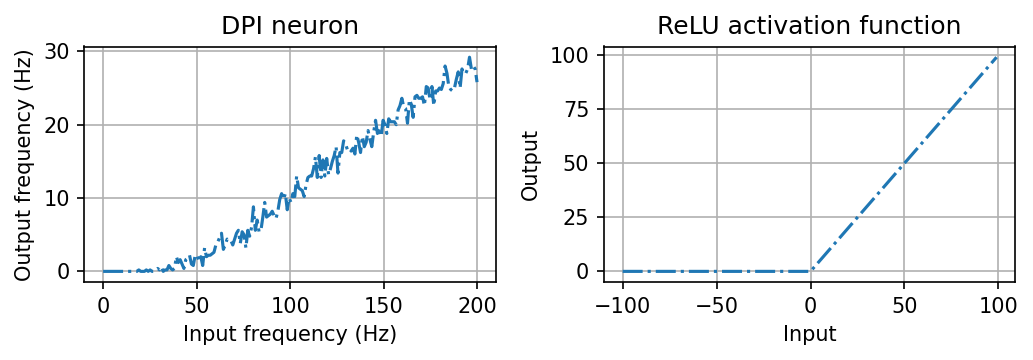

In [ ]:
plt.figure(figsize=(7,2.5),dpi=150)
plt.subplot(121)
plot(np.linspace(freq_start, freq_stop, num_neurons), mon_neuron_output.count/ inp_duration * 1000 * ms,'-.') # Count number of spikes per neuron
plt.xlabel('Input frequency (Hz)')
plt.ylabel('Output frequency (Hz)')
plt.title('DPI neuron')
plt.grid(True)
plt.subplot(122)
plot(np.arange(-100,100,1),np.maximum(0,np.arange(-100,100,1)),'-.') # Implement ReLU function
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('ReLU activation function')
plt.grid(True)
plt.tight_layout()

There are a few things to notice in the figure above.

- Neurons did not fire until a certain input firing rate is reached.
- The input/output spike-rate relation resembles the ReLU activation function of ANNs.
- The F-F curve looks noisy. It is because of the stochastic nature of the Poisson inputs. The variance can be decreased by simulating the network over a longer time period.
- When the output frequency is non-zero it looks linear, but we do not expect the firing rate to increase to arbitrary high output frequencies. The firing rate saturates at some point due to the refractory period etc.
- Side note: In cortex, the firing rate of neurons also saturates under large input, but neurons almost always operate in the range of spike rates where the relation is linear.

200 neurons are allocated from Core_1.


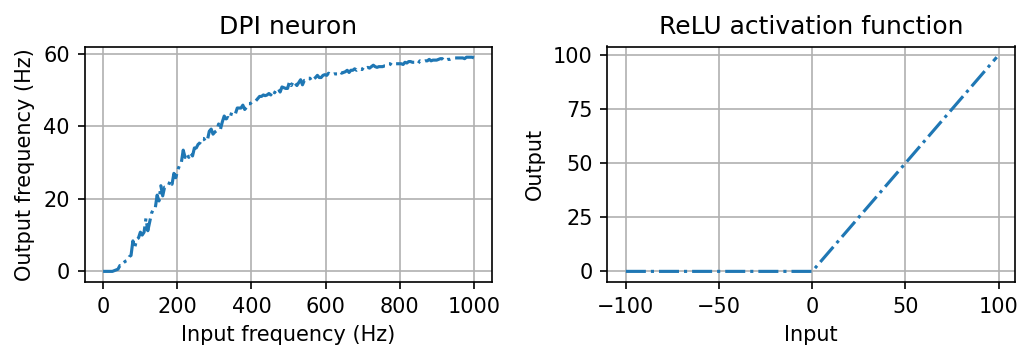

In [ ]:
## Calculating the FF curve of DPI
##################
# TODO:
# - Change the parameters to observe the saturation of FF-curve. (It may depend on various factors)
#
#
##################

## Calculating the F-F curve of DPI neurons
##################
# TODO:
# - Play with frequency range and the simulation duration
#
# Parameters
inp_duration   = 5     # second - Simulation duration (default: 5)
freq_start     = 0     # Hz - Starting frequency (Neuron 0 will be stimulated with this Poisson rate) (default: 0)
freq_stop      = 1000   # Change to 1000 Hz to observe saturation of FF-curve
num_neurons    = 200
##################

# Re-initialize the device
device.reinit()
device.activate()
defaultclock.dt = 20 * us
# Ignore Brian2 base warnings
BrianLogger.suppress_name('base')

# Create a Brian2 network and chip instance using that monitors Dynap-SE1 resources.
network = Network()
chip = DynapSE(network)


# Create [time_steps, source ID] matrix, where firing rate is defined by source ID.
# e.g., source 5 will fire at 5 Hz.
# rates2 = np.tile(np.linspace(freq_start, freq_stop, freq_stop-freq_start), (inp_duration*1000, 1)) # shape: (inp_duration*1000, 256)
rates2 = np.tile(np.linspace(freq_start, freq_stop, num_neurons), (inp_duration*1000, 1)) # shape: (inp_duration*1000, 256)

# Create a TimedArray according to rate information
spike_timing = TimedArray(rates2 * Hz , dt=1 * us)

# Using spike timing function, generate a Spike Generator that creates Poisson spikes
# input_spike_generator = PoissonGroup(freq_stop-freq_start, "spike_timing(t,i)")
input_spike_generator = PoissonGroup(num_neurons, "spike_timing(t,i)")

# Allocate neurons such that each firing frequency will be assigned to single neuron.
# DPI_neuron  = chip.get_neurons(freq_stop-freq_start, 'Core_1')
DPI_neuron  = chip.get_neurons(num_neurons, 'Core_1')
DPI_synapse = chip.add_connection(input_spike_generator, DPI_neuron, synapse_type='NMDA')

# One-to-one (j=i) mapping, instead of all-to-all connection
chip.connect(DPI_synapse, j='i')
DPI_synapse.weight = 300

# Monitors
mon_neuron_input  = SpikeMonitor(input_spike_generator, name='mon_neuron_input')
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')
network.add([input_spike_generator, DPI_neuron, DPI_synapse, mon_neuron_input, mon_neuron_output])

# Simulation
network.run(inp_duration * 1000 * ms)

# Plot
plt.figure(figsize=(7,2.5),dpi=150)
plt.subplot(121)
plot(np.linspace(freq_start, freq_stop, num_neurons), mon_neuron_output.count/ inp_duration * 1000 * ms,'-.') # Count number of spikes per neuron
plt.xlabel('Input frequency (Hz)')
plt.ylabel('Output frequency (Hz)')
plt.title('DPI neuron')
plt.grid(True)
plt.subplot(122)
plot(np.arange(-100,100,1),np.maximum(0,np.arange(-100,100,1)),'-.') # Implement ReLU function
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('ReLU activation function')
plt.grid(True)
plt.tight_layout()

The slope of a neuron's F-F curve depends on many factors including the time constant of its input synapses and their synaptic efficacies. In the cell below, we compared F-F curves of DPI neurons with `AMPA` and `NMDA` synapses with three different weight strengths.

In [ ]:
syn_type_list   = ['AMPA', 'NMDA']
syn_weight_list = [300, 400, 500]

freq_start     = 0     # Hz - Starting frequency (Neuron 0 will be stimulated with this Poisson rate) (default: 0)
freq_stop      = 200   # Hz - Stop frequency (The last neuron will be stimulated with this Poisson rate) (default: 200)

spike_counts = np.zeros((6,200))
for ix, synapse_type in enumerate(syn_type_list):
    # Reinitialize the device
    device.reinit()
    device.activate()
    defaultclock.dt = 20 * us

    # Create a DynapSE instance
    network = Network()
    chip = DynapSE(network)

    # New input generator
    rates3 = np.tile(np.linspace(freq_start, freq_stop, freq_stop-freq_start), (5*1000, 1)) # shape: (inp_duration*1000, 256)
    spike_timing = TimedArray(rates3 * Hz , dt=1 * us)
    input_spike_generator = PoissonGroup(freq_stop-freq_start, "spike_timing(t,i)")

    # 200 neurons from Core 0
    neurons_0  =  chip.get_neurons(freq_stop-freq_start, 'Core_0')
    synapses_0 =  chip.add_connection(input_spike_generator, neurons_0, synapse_type=synapse_type)
    chip.connect(synapses_0, j='i')
    synapses_0.weight = syn_weight_list[0]
    mon_neuron_output_0 = SpikeMonitor(neurons_0, name='mon_neuron_output_0')

    # 200 neurons from Core 1
    neurons_1  =  chip.get_neurons(freq_stop-freq_start, 'Core_1')
    synapses_1 =  chip.add_connection(input_spike_generator, neurons_1, synapse_type=synapse_type)
    chip.connect(synapses_1, j='i')
    synapses_1.weight = syn_weight_list[1]
    mon_neuron_output_1 = SpikeMonitor(neurons_1, name='mon_neuron_output_1')

    # 200 neurons from Core 2
    neurons_2  =  chip.get_neurons(freq_stop-freq_start, 'Core_2')
    synapses_2 =  chip.add_connection(input_spike_generator, neurons_2, synapse_type=synapse_type)
    chip.connect(synapses_2, j='i')
    synapses_2.weight = syn_weight_list[2]
    mon_neuron_output_2 = SpikeMonitor(neurons_2, name='mon_neuron_output_2')

    # Monitors
    network.add([input_spike_generator, neurons_0, neurons_1, neurons_2, synapses_0, synapses_1, synapses_2, mon_neuron_output_0, mon_neuron_output_1, mon_neuron_output_2])

    # Simulation
    network.run(inp_duration * 1000 * ms)

    # Save
    spike_counts[3*ix+0,:] = mon_neuron_output_0.count/inp_duration
    spike_counts[3*ix+1,:] = mon_neuron_output_1.count/inp_duration
    spike_counts[3*ix+2,:] = mon_neuron_output_2.count/inp_duration
    print('Reseting the chip settings ...')

200 neurons are allocated from Core_0.


WARNING    The object 'poissongroup' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '<ipython-input-19-278542eb0aff>', line 18, in <cell line: 5>
    input_spike_generator = PoissonGroup(freq_stop-freq_start, "spike_timing(t,i)") [brian2.core.base.unused_brian_object]


200 neurons are allocated from Core_1.
200 neurons are allocated from Core_2.
Reseting the chip settings ...
200 neurons are allocated from Core_0.
200 neurons are allocated from Core_1.
200 neurons are allocated from Core_2.
Reseting the chip settings ...


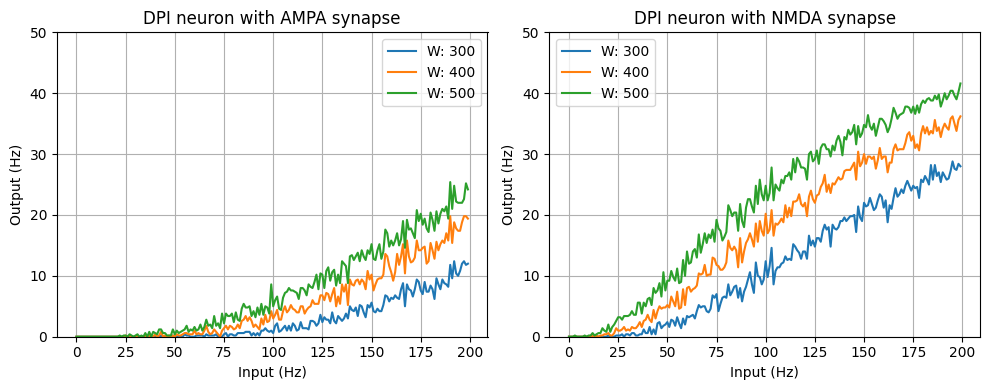

In [ ]:
# Plot the results
plt.figure(figsize=(10,4), dpi=100)
for i in range(2):
    plt.subplot(120+i+1)
    plt.title(f'DPI neuron with {syn_type_list[i]} synapse')
    for j in range(3):
        plt.plot(spike_counts[3*i+j], label=f'W: {syn_weight_list[j]}')
        plt.xlabel('Input (Hz)')
        plt.ylabel('Output (Hz)')
        plt.ylim([0,50])
        plt.legend()
        plt.grid()
plt.tight_layout()

### NMDA: With longer decay time, they produce more prolonged postsynaptic potentials, which can help maintain the neuron's membrane potential above the threshold for a longer duration, leading to a higher firing rate, and more quickly to saturate.

This is the end of Part 2.

---

# Part 3: Spike-Frequency Adaptation of DPI Neurons

Do you remember when a smell seems to be fading after you get used to it? Such mechanisms can be implemented with spike-frequency adaptation.

In neuroscience, spike-frequency adaptation is defined as reducing a neuron's firing rate to a stimulus of constant intensity. Hence, when stimulated with a constant stimulus, many neurons initially respond with a high spike frequency that decays down to a lower steady-state frequency. There are several mechanisms by which neurons can adapt to new stimulus statistics; for example, neurons can change their time constants or other neurons suppress its firing rate via feedback inhibition. Usually, these adaptation processes are slower than the dynamics of action potential generation.

As explained briefly in the Introduction of Part 1, silicon neurons on DynapSE are capable of spike-frequency adaptation. In the DYNAP-SE1 silicon neurons, the spike-frequency adaptation mechanism is implemented by an additional DPI filter that models the neuron's Calcium conductance, producing and after-hyper-polarizing (AHP) current $I_{ahp}$ which is proportional to the neuron's mean firing rate.

There are two bias currents on the chip to tune the strength of the spike-frequency adaptation (see the figure of the DPI circuit at the top and related differential equation approximation):

- $I_{tauahp}$ : Leakage current for spike-frequency adaptation (how fast the adaptation is)
- $I_{thahp}$  : Threshold for spike-frequency adaptation (strength of the adaptation)

Adaptation will then follow from the physics of the silicon and DPI circuit.

In Part 1 and Part 2, we created various spike trains, allocated neurons, and created synapses on the Dynap-SE1 simulator. In Part 3, we will learn another fundamental block of our neuromorphic chips, called Bias Generator (BiasGen).

BiasGen is a configurable current generator that biases the gate voltage of specific transistors on the chip to generate the desired currents. By BiasGen, the user can adjust neuron and synapse parameters and thus resembles "hyperparameters" of ANN. In research, we spend a notable amount of time tuning network parameters via BiasGen so that the network operates in a specific regime that we choose.  You can check the original paper of BiasGen [here](https://ieeexplore.ieee.org/document/5537475). The current version of BiasGen inside the Dynap-SE1 is much more advanced. For example, it can compensate the temperature dependency of generated currents. Despite this compensation, neuromorphic chips operating in the analog regime can be sensitive to temperature variations, see for example Figure 6 in this [paper](https://doi.org/10.3389/fnins.2020.00150), which is based on experiments with a DYNAP-SE1.

In the following you will create a regular spiking pattern and tune two biases, `Itauahp` and `Ithahp,` for observing a spike-frequency adaptation. With correct values, you should see the firing rate adapting to the constant stimulus after some time.

To control BiasGen, you will use the `set_bias(dict, 'core_ID')` method, which takes a dictionary of address, current pairs, and the Core ID. Core ID is required because the biases are shared within a single core of DynapSE.

In [ ]:
## Observing Adaptation Effect
##################
# TODO:
# - Play with Itauahp and Ithahp currents to observe a spike-frequency adaptation
#
#
# Parameters
pulse_start  = 1     # second - Start timing of pulse
pulse_stop   = 4     # second - Stop timing of pulse
inp_duration = 5     # second - Simulation duration
firing_rate  = 150   # Hz - Firing rate of the source

adaptation_conf = {"Itauahp": 0.04 * pA,  # Adaptation time constant (Default: 0.04 pA, 0.05 pA)
                   "Ithahp" : 0.05 * pA}  # Adaptation gain

# adaptation_conf = {"Itauahp": 0.1 * pA,  # Adaptation time constant (Default: 0.04 pA, 0.05 pA)
#                    "Ithahp" : 0.1 * pA}  # Adaptation gain


ampa_conf       = {"I_tau_syn_ampa": 10 * pA, # AMPA synapse time-constant (Default: 10 pA, 10pA)
                   "I_g_syn_ampa"  : 10 * pA} # AMPA synapse gain

##################

# Reinitialize the device
#set_device('cpp_standalone', build_on_run=True) # Requires a compiler
device.reinit()
device.activate()
defaultclock.dt = 20 * us
# Ignore Brian2 base warnings
BrianLogger.suppress_name('base')

# Create a regular spiking pattern (taken from Part 1.)
spikes = np.zeros(inp_duration*1000)
dt = int(1000/firing_rate)
spikes[pulse_start*1000:pulse_stop*1000:dt] = 1.0
spike_timing = np.where(spikes==1)[0] * ms
neuron_indices = np.zeros(len(spike_timing))
input_spike_generator = SpikeGeneratorGroup(1, indices=neuron_indices, times=spike_timing, name='InpSpikeGenerator')

# Create a Brian2 network and chip instance using that monitors DynapSE resources.
network = Network()
chip = DynapSE(network)

# Connect a single spike generator to a single DPI neuron
DPI_neuron  = chip.get_neurons(1, 'Core_1')
DPI_synapse = chip.add_connection(input_spike_generator, DPI_neuron, synapse_type='AMPA')
chip.connect(DPI_synapse, True)
DPI_synapse.weight = 500


# Using BiasGen, set adaptation configurations for Core #1
# In DynapSE, biases are set per Core.
# In CTXCTL, this command is : set_bias(chip_id, bias_id, fine_value, coarse_value, t_type)
chip.set_bias(adaptation_conf, 'Core_1')
chip.set_bias(ampa_conf, 'Core_1')


# Monitors
mon_neuron_input  = SpikeMonitor(input_spike_generator, name='mon_neuron_input')
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')
mon_adapt_state  = StateMonitor(DPI_neuron,  'Iahp', record=True)
mon_mem_state  = StateMonitor(DPI_neuron,  'Imem', record=True)
network.add([input_spike_generator, DPI_neuron, DPI_synapse, mon_neuron_input, mon_neuron_output,mon_adapt_state,mon_mem_state])

# Simulation
network.run(inp_duration * 1000 * ms)

1 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.


Now, you will monitor the input-output spikes, membrane current, and the adaptation current. If you set up the spike-adaptation currents correctly, you will see that the neuron firing rate will decrease in the presence of a constant input rate. However, be aware that tuning the spike-frequency is a bit tricky, and its effect is clearly visible only in a small range of parameter values.

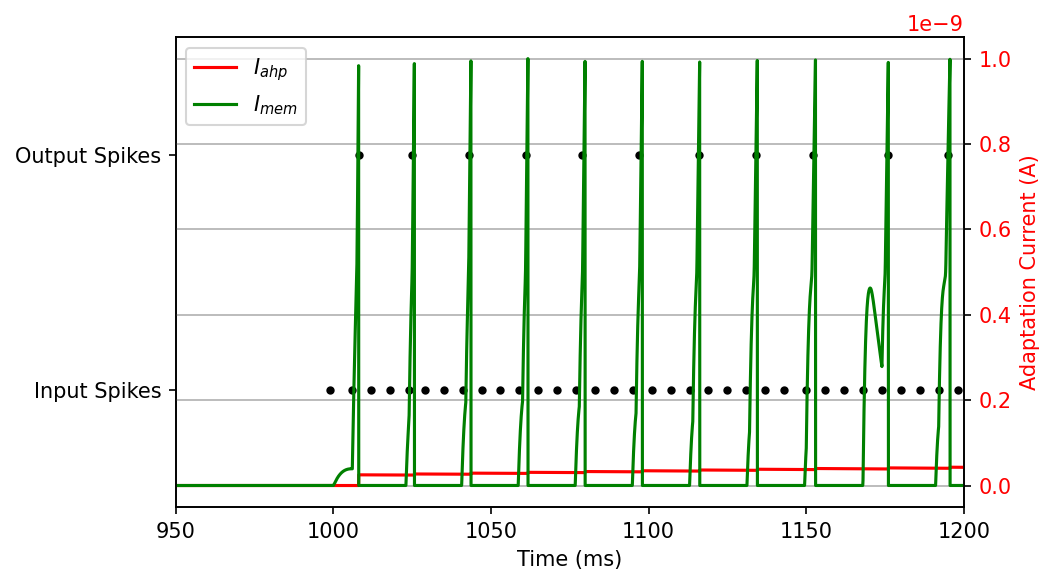

In [ ]:
##################
#  TODO:
# - Find the time window to observe spike-frequency adaptation.
#
# Parameters
tstart = 950 # ms -
tend   = 1200 # ms -
##################

# Plotting
spike_placeholder = np.zeros(inp_duration*1000)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=2

spike_placeholder2 = np.zeros(inp_duration*1000)
spike_placeholder2[np.array(mon_neuron_output.t/ms, dtype=int)]=3

s = int(1*ms / defaultclock.dt)
fig, ax1 = plt.subplots()

fig.set_size_inches(7,4)
fig.set_dpi(150)
ax1.set_xlabel('Time (ms)')
ax1.plot(spike_placeholder,'k.')
plt.yticks(np.arange(1, 5), ['a','Input Spikes','Output Spikes','d'])
ax1.tick_params(axis='y')
plt.ylim(1.5, 3.5)
plt.xlim(tstart,tend)
ax2 = ax1.twinx()
ax1.plot(spike_placeholder2,'k.')

ax2.set_ylabel('Adaptation Current (A)', color='r')
ax2.plot(mon_adapt_state.t/ms, mon_adapt_state.Iahp[0], linewidth=1.5,color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.xlim(tstart,tend)


fig.tight_layout()
plt.grid(True)

ax2.plot(mon_mem_state.t/ms, mon_mem_state.Imem[0], linewidth=1.5, color='g')
plt.legend(['$I_{ahp}$','$I_{mem}$','c'])
plt.show()

You can plot the inter-spike interval (ISI) of the output spikes to more clearly visualize the effect. The ISI is the time between two subsequent spikes, which can be computed with the NumPy diff() function.

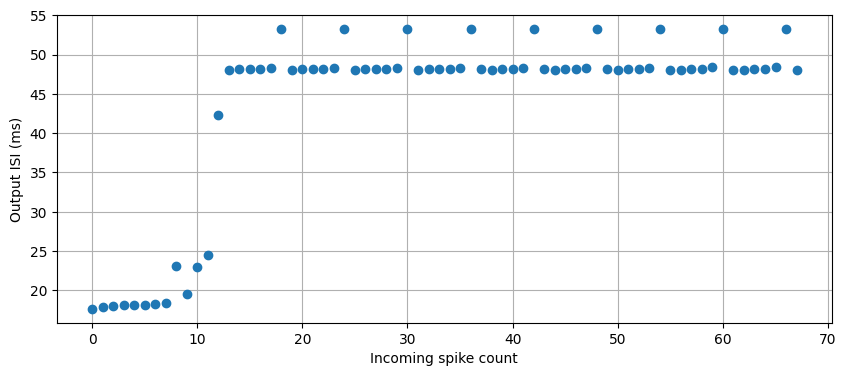

In [ ]:
# Plotting output ISI
plt.figure(figsize=(10,4),dpi=100)
plot(np.diff(mon_neuron_output.t/ms),'o')
plt.ylabel('Output ISI (ms)')
plt.xlabel('Incoming spike count')
plt.grid(True)

###
Itauahp (Leakage Current for Spike-Frequency Adaptation): It determines how quickly the adaptation occurs. A higher Itauahp value means the adaptation happens faster, leading to a quicker reduction in the neuron's firing rate after an initial burst of activity. Conversely, a lower Itauahp value results in slower adaptation, allowing the neuron to maintain a higher firing rate for a longer period before adapting.

Ithahp (Threshold for Spike-Frequency Adaptation): It sets the strength of the adaptation. A higher Ithahp value increases the threshold for adaptation, making the neuron less sensitive to changes in firing rate and thus requiring stronger or more prolonged input to trigger adaptation. A lower Ithahp value makes the neuron more sensitive, causing adaptation to occur more readily even with weaker inputs.

Congratulations! This is the end of the exercise.

You should now show your solutions to one of the teachers during a scheduled lab session, either physically in the computer lab on campus or remotely in Zoom. Instructions for how to sign up for showing your solution is available in Canvas.